# Import Libraries

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time

# from sklearn.feature_selection import f_regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor

from lazypredict.Supervised import LazyRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


Display more decimals for pandas

In [4]:
pd.set_option('display.float_format', '{:.5f}'.format)

# Data Cleaning

In [5]:
# Import Data:
Ames_HousePrice = pd.read_csv('Ames_HousePrice.csv', index_col=0)
real_coords = pd.read_csv("real_estate_with_coordinates.csv")

# One row is duplicated in Ames_HousePrice df, once dropped there are no duplicate PID values
Ames_HousePrice = Ames_HousePrice.drop_duplicates()
real_coords = real_coords.drop_duplicates()

# Dataframe merging
real_estate_columns_to_keep = ['GeoRefNo','Prop_Addr', 'MA_Zip1','latitude', 'longitude']
housing_coords = pd.merge(Ames_HousePrice, real_coords[real_estate_columns_to_keep],
                               left_on='PID', right_on='GeoRefNo', how='left')

# Remove any duplicate rows created in merge
housing_coords = housing_coords.drop_duplicates()

# Remove outliers 528351010 has too high sale price, 908154205, has too much area
housing_coords = housing_coords[~housing_coords['PID'].isin([528351010, 908154205])]

# Drop Columns with too many NA Values
# housing_coords.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'],axis=1,inplace=True)

# Update missing gps data rows:
# housing_coords = housing_coords.dropna(subset=['latitude'])
mean_latitude = housing_coords['latitude'].mean()
housing_coords['latitude'].fillna(mean_latitude, inplace=True)

mean_longitude = housing_coords['longitude'].mean()
housing_coords['longitude'].fillna(mean_longitude, inplace=True)

# DistanceToISU column contains the distance of each property to Iowa State University
# Coordinates of Iowa State University
isu_latitude = 42.0239
isu_longitude = -93.6476
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in miles
    radius = 3958.8
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    # Differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Calculate the distance
    distance = radius * c
    return distance
# Calculate distance for each property address
housing_coords['DistanceToISU'] = housing_coords.apply(
    lambda row: haversine(row['latitude'], row['longitude'], isu_latitude, isu_longitude), axis=1)

# 2 rows with gps info but missing zip:
specified_addresses = ['2010 KILDEE ST', '1310 WOODSTOCK AVE']
# Update 'Zipcode' to 50014 where 'Address' is in the specified list
housing_coords.loc[housing_coords['Prop_Addr'].isin(specified_addresses), 'MA_Zip1'] = 50014
    
# 'Prop_Addr' column useful for EDA and data cleaning but not for modeling
housing_coords.drop('Prop_Addr',axis=1,inplace=True)

# Reset index after dropping rows so flitering by iloc works smoothly
housing_coords.reset_index(drop=True,inplace=True)

# This is good for EDA but since it is calculated from the target it will cause 
# data leakage and shouldn't be included in modeling
    # # Added PricePerSF Column
    # housing_coords['PricePerSF'] = housing_coords['SalePrice'] / housing_coords['GrLivArea']

# Delete utilities column, it has 2496/2497 with same value
    # housing_coords.Utilities.value_counts() # <-- No N/As here
housing_coords.drop('Utilities',axis=1,inplace=True)

# Fix Row with Missing Values in Basement Categories
housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
    'BsmtFullBath','BsmtHalfBath']] = housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(0)

# Masonry Veneer (Type/Area)
    # If Type = 'None' but Area != 0, Type updated to mode
    # N/As updated to None for Type and 0 for Area
idx = (housing_coords['MasVnrArea'].isna()) & (housing_coords['MasVnrType'].isna())
housing_coords.loc[idx, 'MasVnrArea'] = housing_coords.loc[idx, 'MasVnrArea'].fillna(0)
housing_coords.loc[idx, 'MasVnrType'] = housing_coords.loc[idx, 'MasVnrType'].fillna('None')
mode_MasVnrType = housing_coords.loc[housing_coords.MasVnrType!='None'].MasVnrType.mode()[0]
idx2 = (housing_coords['MasVnrArea']!=0) & (housing_coords['MasVnrType']== 'None')
housing_coords.loc[idx2, 'MasVnrType'] = housing_coords.loc[idx2, 'MasVnrType'].fillna(mode_MasVnrType)

# Fix Row with Missing Values in GarageCars & GarageArea Categories
idx3 = (housing_coords['GarageArea']!=0) & (housing_coords['GarageType']=='Detchd')
mean_GarageArea = round(housing_coords.loc[idx3, 'GarageArea'].mean())
housing_coords.loc[housing_coords.PID==910201180,'GarageArea'] = mean_GarageArea
idx4 = housing_coords['GarageType']=='Detchd'
mode_GarageCars = housing_coords.loc[idx4, 'GarageCars'].mode()[0]
housing_coords.loc[housing_coords.PID==910201180,'GarageCars'] = mode_GarageCars

# Fill GarageYrBlt to match Year House Was Built
housing_coords['GarageYrBlt'] = housing_coords['GarageYrBlt'].fillna(housing_coords['YearBuilt']) # 129 N/A

# Fix Row where Year Remodeled occured before Year Built
housing_coords.loc[housing_coords.PID==907194160,'YearRemodAdd'] = \
housing_coords.loc[housing_coords.PID==907194160,'YearBuilt']

# Fill with Most Common (Categorical) Value:
mode_Electrical = housing_coords['Electrical'].mode()[0] # 1 N/A
housing_coords['Electrical'].fillna(mode_Electrical, inplace=True)

# 451 N/A values for Lot Frontage
    # The average ratio of LotFrontage/LotArea was calculated for each
    # LotType & LotShape and this percentage factor was used to calculate
    # The missing LotFrontage Values (since LotArea was not missing)
lot_df = housing_coords.loc[housing_coords['LotFrontage'].notna()][[
    'LotFrontage','LotArea','LotConfig','LotShape']]
lot_df2 = lot_df.groupby(['LotConfig','LotShape']).agg({'LotFrontage':'mean','LotArea':'mean'})
lot_df2['PCT_Frontage']=lot_df2['LotFrontage']/lot_df2['LotArea']
percentage_factor_mapping = lot_df2['PCT_Frontage'].to_dict()

# Update the NaN values in 'LotFrontage' using the mapping and LotArea
housing_coords['LotFrontage'] = housing_coords.apply(
    lambda row: round(row['LotArea'] * percentage_factor_mapping.get(
        (row['LotConfig'], row['LotShape']), 1.0)), axis=1)

# Combine Full and Half Bathroom Categories
housing_coords['BsmtBath']=housing_coords['BsmtFullBath']+0.5*housing_coords['BsmtHalfBath']
housing_coords['Bath']=housing_coords['FullBath']+0.5*housing_coords['HalfBath']
housing_coords.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'],axis=1,inplace=True)
mean_BsmtBath = round(housing_coords.BsmtBath.mean()*2)/2 # Round to nearest 0.5
housing_coords['BsmtBath'].fillna(mean_BsmtBath, inplace=True)

# Replace TotRmsAbvGrd with MiscRmsAbvGrd to avoid multicollinearity?
    # These are not bedroom, kitchen, nor bathroom
housing_coords['MiscRmsAbvGrd'] = housing_coords.TotRmsAbvGrd - housing_coords.BedroomAbvGr - housing_coords.KitchenAbvGr
housing_coords.drop('TotRmsAbvGrd',axis=1,inplace=True)

# Change YearBuilt to Age so it works better as a numerical variable
housing_coords['Age'] = housing_coords['YrSold'] - housing_coords['YearBuilt']
housing_coords.drop('YearBuilt',axis=1,inplace=True)

# Fill NaN with 'None' for categorical columns
missing_categorical_features = ['FireplaceQu', 'GarageCond','GarageQual','GarageFinish', 'MasVnrType',
                                'GarageType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'Alley',
                                'BsmtFinType2', 'BsmtExposure', 'PoolQC', 'MiscFeature', 'Fence' ]
housing_coords[missing_categorical_features] = housing_coords[missing_categorical_features].fillna('None')

# Drop PID & GeoRefNo. They are only needed for merging
housing_coords.drop(['GeoRefNo', 'PID'],axis=1,inplace=True)

# Replace MSSubClass numerical values with letter values since it is categorical
MSSubClass_mapping_dict = {20:'A', 30:'B', 40:'C', 45:'D', 50:'E', 60:'F', 70:'G', 75:'H', 
                           80:'I', 85:'J', 90:'K', 120:'L', 150:'M', 160:'N', 180:'O', 190:'P'}
housing_coords['MSSubClass'] = housing_coords['MSSubClass'].replace(MSSubClass_mapping_dict)

# Update Zip Code Column.  There are only a few zips listed actually in Ames. The rest are
    # changed to 'other' rather than search the address and update to the appropriate one.
    # The column is also treated as a categorical variable
housing_coords['MA_Zip1'].fillna(99, inplace=True)
housing_coords['MA_Zip1'] = housing_coords['MA_Zip1'].astype(int)
housing_coords['MA_Zip1'] = housing_coords['MA_Zip1'].astype(str)
zip_update = ~housing_coords['MA_Zip1'].isin(['99','50010', '50011', '50012', '50013', '50014'])
housing_coords.loc[zip_update, 'MA_Zip1'] = 'other'

# Addition of Total Square Feet Column:
housing_coords['TotalSF'] = housing_coords.GrLivArea + housing_coords.TotalBsmtSF

print(f'Shape of DataFrame: {housing_coords.shape}')

Shape of DataFrame: (2577, 82)


# Convert Ordinal Numeric Columns to Numeric

In [6]:
numeric_df = housing_coords.select_dtypes(include='number')
corr_sorted_numerical_columns = abs(numeric_df.corr())['SalePrice'].sort_values(ascending=False).drop(['SalePrice'])
numerical_columns = list(corr_sorted_numerical_columns.index)
numerical_columns.sort()
categorical_columns = list(set(housing_coords.columns) - set(numeric_df.corr()['SalePrice'].index))
categorical_columns.sort()
ordinal_columns = ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 
                   'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual', 'BsmtExposure',
                  'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'LandSlope',
                  'LotShape', 'PoolQC']
non_ordinal_columns = list(set(categorical_columns)-set(ordinal_columns))
non_ordinal_columns.sort()
all_cols = list(housing_coords.columns)
all_cols.sort()

print('Initial Counts:')
print(f'{len(numerical_columns)} Numerical Columns')
print(f'{len(categorical_columns)} Total Categorical Columns')
print(f'{len(non_ordinal_columns)} Non-Ordinal Categorical Columns')



# Ordinal Column Mapping
qual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
qual_ordinal_columns = ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 
                        'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual']
for col in qual_ordinal_columns:
    col_numerical = f'{col}_n'
    housing_coords[col_numerical] = housing_coords[col].map(qual_mapping)

BsmtExposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
housing_coords['BsmtExposure_n'] = housing_coords['BsmtExposure'].map(BsmtExposure_mapping)

BsmtFinType_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
housing_coords['BsmtFinType1_n'] = housing_coords['BsmtFinType1'].map(BsmtFinType_mapping)
housing_coords['BsmtFinType2_n'] = housing_coords['BsmtFinType2'].map(BsmtFinType_mapping)

Functional_mapping = {'Typ':7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
housing_coords['Functional_n'] = housing_coords['Functional'].map(Functional_mapping)

GarageFinish_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
housing_coords['GarageFinish_n'] = housing_coords['GarageFinish'].map(GarageFinish_mapping)

LandSlope_mapping = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
housing_coords['LandSlope_n'] = housing_coords['LandSlope'].map(LandSlope_mapping)

LotShape_mapping = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
housing_coords['LotShape_n'] = housing_coords['LotShape'].map(LotShape_mapping)

PoolQC_mapping = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0}
housing_coords['PoolQC_n'] = housing_coords['PoolQC'].map(PoolQC_mapping)

housing_coords.drop(ordinal_columns, axis=1, inplace=True)


# NEW COUNTS
numeric_df = housing_coords.select_dtypes(include='number')
corr_sorted_numerical_columns = (numeric_df.corr()['SalePrice']).sort_values(ascending=False).drop(['SalePrice'])
numerical_columns = list(corr_sorted_numerical_columns.index)
numerical_columns.sort()
categorical_columns = list(set(housing_coords.columns) - set(numeric_df.corr()['SalePrice'].index))
categorical_columns.sort()

print('\nUpdated Counts:')
print(f'{len(numerical_columns)} Numerical Columns')
print(f'{len(categorical_columns)} Categorical Columns')

Initial Counts:
37 Numerical Columns
44 Total Categorical Columns
27 Non-Ordinal Categorical Columns

Updated Counts:
54 Numerical Columns
27 Categorical Columns


Create df with dummies and df with numerical values for categorical columns

In [7]:
df_with_dummies = pd.get_dummies(housing_coords, columns=categorical_columns, drop_first=False)
sorted_features_dummies = list(abs(df_with_dummies.corr()[['SalePrice']]).sort_values('SalePrice',ascending=False).drop(['SalePrice']).head(25).index)

df_numerical = housing_coords.copy()
for feature in categorical_columns:
    col_map = {}
    for i in range(len(df_numerical[feature].unique())):
        col_map[list(df_numerical[feature].unique())[i]] = i+1
    df_numerical[feature] = df_numerical[feature].map(col_map)

sorted_features_numerical = abs(df_numerical.corr()[['SalePrice']]).sort_values('SalePrice',ascending=False).drop(['SalePrice']).head(25).index

# Code to run so you are alerted something else has finished

# Set X, y, and train/test split

In [8]:
X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# min_samples_split changes with n_estimators

In [9]:
# Approximate total time = 3300 seconds (55 mins)
start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(max_depth=3, learning_rate=0.01, subsample=0.3, random_state=42)
results_list_min_samples_split = []
n_estimators_values = list(range(100, 9100, 1000))
min_samples_split_values = [2, 3, 4, 5, 10, 25]  #, 50, 75, 100]

for n_estimators in n_estimators_values:
    gbmr.set_params(n_estimators=n_estimators)

    for min_samples_split in min_samples_split_values:
        gbmr.set_params(min_samples_split=min_samples_split)
        r2_scorelist = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
            start_time2 = time.time()
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            gbmr.fit(X_train, y_train)
            y_pred = gbmr.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            r2_scorelist.append(r2)
        
            # end_time2 = time.time()
            # elapsed_time2 = end_time2 - start_time2
            # print(f"min_samples_split {min_samples_split} Fold {fold} Completed. Fold Time: {elapsed_time2:.2f} seconds")
        
        mean_r2 = sum(r2_scorelist) / len(r2_scorelist)
        results_list_min_samples_split.append({'MeanR2': mean_r2, 'min_samples_split': min_samples_split, 'n_estimators':n_estimators})

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{n_estimators} n_estimators Completed. Total Elapsed Time: {elapsed_time:.2f} seconds")

results_df_temp = pd.DataFrame(results_list_min_samples_split)
r2_df1 = results_df_temp.pivot(index='min_samples_split', columns='n_estimators', values='MeanR2')

100 n_estimators Completed. Total Elapsed Time: 8.98 seconds
1100 n_estimators Completed. Total Elapsed Time: 106.08 seconds
2100 n_estimators Completed. Total Elapsed Time: 291.53 seconds
3100 n_estimators Completed. Total Elapsed Time: 563.43 seconds
4100 n_estimators Completed. Total Elapsed Time: 922.95 seconds
5100 n_estimators Completed. Total Elapsed Time: 1372.21 seconds
6100 n_estimators Completed. Total Elapsed Time: 1917.20 seconds
7100 n_estimators Completed. Total Elapsed Time: 2555.27 seconds
8100 n_estimators Completed. Total Elapsed Time: 3283.87 seconds


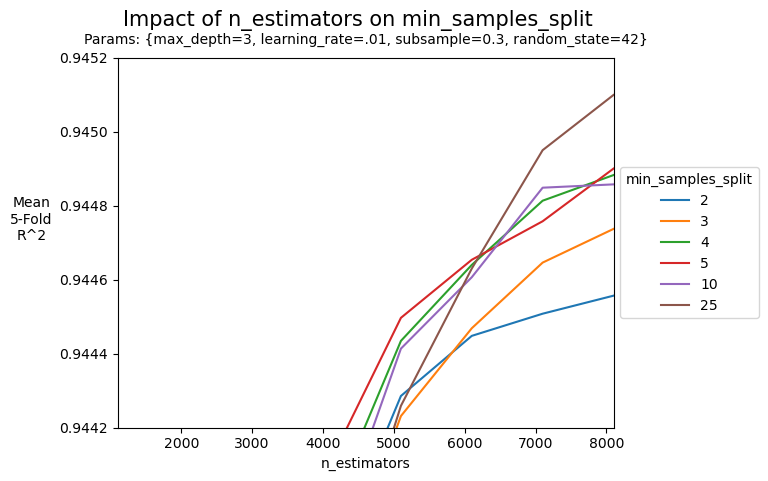

In [474]:
# PLOT - min_samples_split changes with n_estimators
r2_df1.T.plot(linestyle='-')
plt.xlabel('n_estimators')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.suptitle('Impact of n_estimators on min_samples_split', fontsize=15)
plt.title('Params: {max_depth=3, learning_rate=.01, subsample=0.3, random_state=42}', fontsize=10, pad=10)
plt.ylim(0.935,0.95)
plt.ylim(0.9442,0.9452)
plt.xlim(1100,8100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('min_samples_split')

# learning_rate changes with n_estimators

In [11]:
# Approximate total time = 2725 seconds (44 mins)
start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(max_depth=3, learning_rate=0.01, min_samples_split=5, subsample=0.3, random_state=42)
results_list_learning_rate = []
n_estimators_values = list(range(100, 9100, 1000))
learning_rate_values = [0.0125, 0.011, 0.01, 0.009, 0.0075]

for n_estimators in n_estimators_values:
    gbmr.set_params(n_estimators=n_estimators)

    for learning_rate in learning_rate_values:
        gbmr.set_params(learning_rate=learning_rate)
        r2_scorelist = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
            start_time2 = time.time()
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            gbmr.fit(X_train, y_train)
            y_pred = gbmr.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            r2_scorelist.append(r2)
        
            # end_time2 = time.time()
            # elapsed_time2 = end_time2 - start_time2
            # print(f"learning_rate {learning_rate} Fold {fold} Completed. Fold Time: {elapsed_time2:.2f} seconds")
        
        mean_r2 = sum(r2_scorelist) / len(r2_scorelist)
        results_list_learning_rate.append({'MeanR2': mean_r2, 'learning_rate': learning_rate, 'n_estimators':n_estimators})

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{n_estimators} n_estimators Completed. Total Elapsed Time: {elapsed_time:.2f} seconds")

results_df_temp = pd.DataFrame(results_list_learning_rate)
r2_df2 = results_df_temp.pivot(index='learning_rate', columns='n_estimators', values='MeanR2')

100 n_estimators Completed. Total Elapsed Time: 7.62 seconds
1100 n_estimators Completed. Total Elapsed Time: 89.85 seconds
2100 n_estimators Completed. Total Elapsed Time: 246.71 seconds
3100 n_estimators Completed. Total Elapsed Time: 478.28 seconds
4100 n_estimators Completed. Total Elapsed Time: 785.76 seconds
5100 n_estimators Completed. Total Elapsed Time: 1168.87 seconds
6100 n_estimators Completed. Total Elapsed Time: 1625.63 seconds
7100 n_estimators Completed. Total Elapsed Time: 2158.22 seconds
8100 n_estimators Completed. Total Elapsed Time: 2764.64 seconds


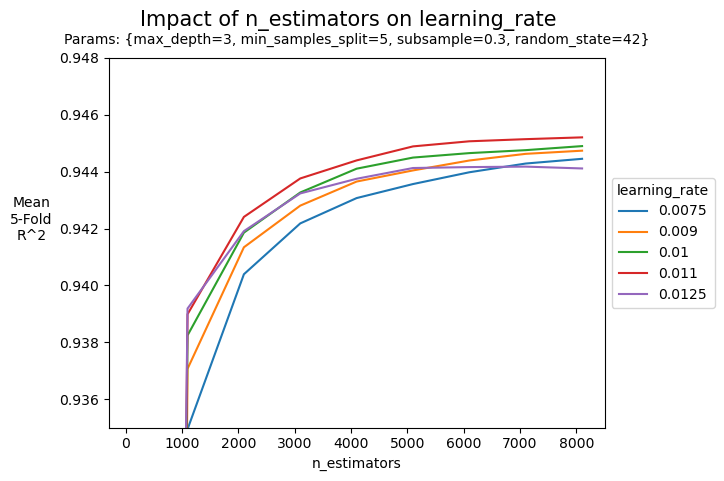

In [479]:
# PLOT - learning_rate changes with n_estimators
r2_df2.T.plot(linestyle='-')
plt.xlabel('n_estimators')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.suptitle('Impact of n_estimators on learning_rate', fontsize=15)
plt.title('Params: {max_depth=3, min_samples_split=5, subsample=0.3, random_state=42}', fontsize=10, pad=10)
plt.ylim(0.935,0.948)
# plt.ylim(0.9375,0.9472)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('learning_rate')

# max_depth changes with n_estimators

In [17]:
# Approximate total time = 2785 seconds (55 mins)
start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(max_depth=3, learning_rate=0.011, min_samples_split=5, subsample=0.3, random_state=42)
results_list_max_depth = []
n_estimators_values = list(range(100, 9100, 1000))
max_depth_values = [3,4,5,6]

for n_estimators in n_estimators_values:
    gbmr.set_params(n_estimators=n_estimators)

    for max_depth in max_depth_values:
        gbmr.set_params(max_depth=max_depth)
        r2_scorelist = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
            start_time2 = time.time()
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            gbmr.fit(X_train, y_train)
            y_pred = gbmr.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            r2_scorelist.append(r2)
        
            # end_time2 = time.time()
            # elapsed_time2 = end_time2 - start_time2
            # print(f"max_depth {max_depth} Fold {fold} Completed. Fold Time: {elapsed_time2:.2f} seconds")
        
        mean_r2 = sum(r2_scorelist) / len(r2_scorelist)
        results_list_max_depth.append({'MeanR2': mean_r2, 'max_depth': max_depth, 'n_estimators':n_estimators})

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{n_estimators} n_estimators Completed. Total Elapsed Time: {elapsed_time:.2f} seconds")

results_df_temp = pd.DataFrame(results_list_max_depth)
r2_df3 = results_df_temp.pivot(index='max_depth', columns='n_estimators', values='MeanR2')

max_depth 6 n_estimators 100 Completed. Total Elapsed Time: 8.68 seconds
max_depth 6 n_estimators 1100 Completed. Total Elapsed Time: 102.57 seconds
max_depth 6 n_estimators 2100 Completed. Total Elapsed Time: 281.85 seconds
max_depth 6 n_estimators 3100 Completed. Total Elapsed Time: 546.62 seconds
max_depth 6 n_estimators 4100 Completed. Total Elapsed Time: 896.94 seconds
max_depth 6 n_estimators 5100 Completed. Total Elapsed Time: 1333.00 seconds
max_depth 6 n_estimators 6100 Completed. Total Elapsed Time: 1859.36 seconds
max_depth 6 n_estimators 7100 Completed. Total Elapsed Time: 2469.56 seconds
max_depth 6 n_estimators 8100 Completed. Total Elapsed Time: 3165.89 seconds


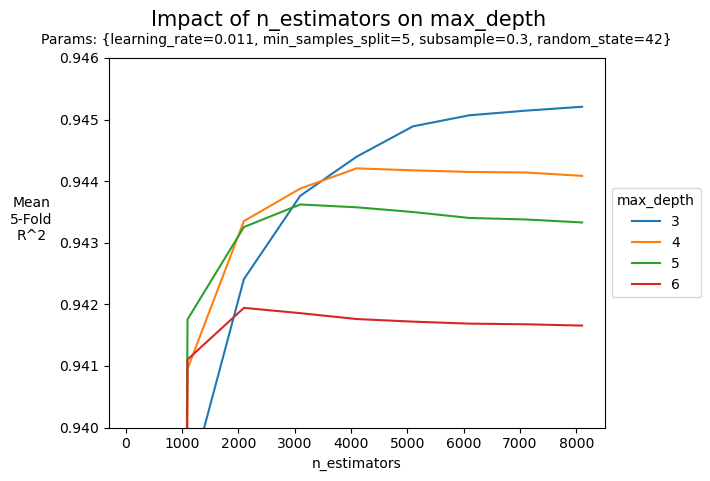

In [478]:
# PLOT - max_depth changes with n_estimators
r2_df3.T.plot(linestyle='-')
plt.xlabel('n_estimators')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.suptitle('Impact of n_estimators on max_depth', fontsize=15)
plt.title('Params: {learning_rate=0.011, min_samples_split=5, subsample=0.3, random_state=42}', fontsize=10, pad=10)
plt.ylim(0.94,0.946)
# plt.ylim(0.9375,0.9472)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('max_depth')

# max_depth changes with n_estimators (only stepped 100-900)

In [20]:
# Approximate total time = 382 seconds
start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(max_depth=3, learning_rate=0.011, min_samples_split=5, subsample=0.3, random_state=42)
results_list_max_depth_a = []
n_estimators_values = list(range(100, 901, 100))
max_depth_values = [3,4,5,6]

for n_estimators in n_estimators_values:
    gbmr.set_params(n_estimators=n_estimators)

    for max_depth in max_depth_values:
        gbmr.set_params(max_depth=max_depth)
        r2_scorelist = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
            start_time2 = time.time()
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            gbmr.fit(X_train, y_train)
            y_pred = gbmr.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            r2_scorelist.append(r2)
        
            end_time2 = time.time()
            elapsed_time2 = end_time2 - start_time2
            print(f"max_depth {max_depth} Fold {fold} Completed. Fold Time: {elapsed_time2:.2f} seconds")
        
        mean_r2 = sum(r2_scorelist) / len(r2_scorelist)
        results_list_max_depth_a.append({'MeanR2': mean_r2, 'max_depth': max_depth, 'n_estimators':n_estimators})

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"max_depth {max_depth} n_estimators {n_estimators} Completed. Total Elapsed Time: {elapsed_time:.2f} seconds")

results_df_temp = pd.DataFrame(results_list_max_depth_a)
r2_df3a = results_df_temp.pivot(index='max_depth', columns='n_estimators', values='MeanR2')

max_depth 3 Fold 1 Completed. Fold Time: 0.32 seconds
max_depth 3 Fold 2 Completed. Fold Time: 0.30 seconds
max_depth 3 Fold 3 Completed. Fold Time: 0.30 seconds
max_depth 3 Fold 4 Completed. Fold Time: 0.30 seconds
max_depth 3 Fold 5 Completed. Fold Time: 0.30 seconds
max_depth 4 Fold 1 Completed. Fold Time: 0.39 seconds
max_depth 4 Fold 2 Completed. Fold Time: 0.40 seconds
max_depth 4 Fold 3 Completed. Fold Time: 0.39 seconds
max_depth 4 Fold 4 Completed. Fold Time: 0.39 seconds
max_depth 4 Fold 5 Completed. Fold Time: 0.39 seconds
max_depth 5 Fold 1 Completed. Fold Time: 0.48 seconds
max_depth 5 Fold 2 Completed. Fold Time: 0.48 seconds
max_depth 5 Fold 3 Completed. Fold Time: 0.48 seconds
max_depth 5 Fold 4 Completed. Fold Time: 0.48 seconds
max_depth 5 Fold 5 Completed. Fold Time: 0.48 seconds
max_depth 6 Fold 1 Completed. Fold Time: 0.57 seconds
max_depth 6 Fold 2 Completed. Fold Time: 0.57 seconds
max_depth 6 Fold 3 Completed. Fold Time: 0.57 seconds
max_depth 6 Fold 4 Completed

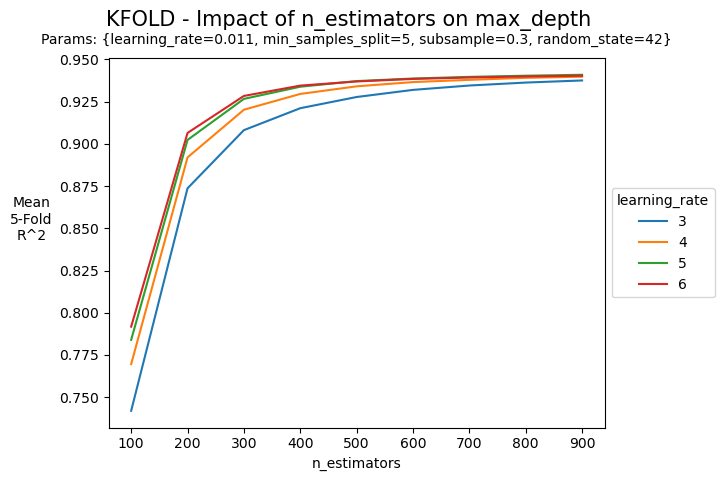

In [21]:
# PLOT - max_depth changes with n_estimators (only stepped 100-900)
r2_df3a.T.plot(linestyle='-')
plt.xlabel('n_estimators')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.suptitle('Impact of n_estimators on max_depth', fontsize=15)
plt.title('Params: {learning_rate=0.011, min_samples_split=5, subsample=0.3, random_state=42}', fontsize=10, pad=10)
# plt.ylim(0.91,0.925)
# plt.ylim(0.9375,0.9472)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('learning_rate')

# max_features changes with n_estimators

In [35]:
# Approximate total time = 2785 seconds (55 mins)
start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(max_depth=3, learning_rate=0.011, min_samples_split=5, subsample=0.3, random_state=42)
results_list_max_features = []
n_estimators_values = list(range(100, 8100, 1000))
max_features_values = [1, 0.9, 0.8, 0.7]

for n_estimators in n_estimators_values:
    gbmr.set_params(n_estimators=n_estimators)

    for max_features in max_features_values:
        gbmr.set_params(max_features=max_features)
        r2_scorelist = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
            start_time2 = time.time()
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            gbmr.fit(X_train, y_train)
            y_pred = gbmr.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            r2_scorelist.append(r2)
        
            # end_time2 = time.time()
            # elapsed_time2 = end_time2 - start_time2
            # print(f"max_features {max_features} Fold {fold} Completed. Fold Time: {elapsed_time2:.2f} seconds")
        
        mean_r2 = sum(r2_scorelist) / len(r2_scorelist)
        results_list_max_features.append({'MeanR2': mean_r2, 'max_features': max_features, 'n_estimators':n_estimators})

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{n_estimators} n_estimators Completed. Total Elapsed Time: {elapsed_time:.2f} seconds")

results_df_temp = pd.DataFrame(results_list_max_features)
r2_df4 = results_df_temp.pivot(index='max_features', columns='n_estimators', values='MeanR2')

max_features 0.7 n_estimators 100 Completed. Total Elapsed Time: 4.19 seconds
max_features 0.7 n_estimators 1100 Completed. Total Elapsed Time: 49.10 seconds
max_features 0.7 n_estimators 2100 Completed. Total Elapsed Time: 136.28 seconds
max_features 0.7 n_estimators 3100 Completed. Total Elapsed Time: 264.38 seconds
max_features 0.7 n_estimators 4100 Completed. Total Elapsed Time: 429.01 seconds
max_features 0.7 n_estimators 5100 Completed. Total Elapsed Time: 640.78 seconds
max_features 0.7 n_estimators 6100 Completed. Total Elapsed Time: 895.27 seconds
max_features 0.7 n_estimators 7100 Completed. Total Elapsed Time: 1191.11 seconds


In [49]:
# adding MORE MAXFEAURES VALUES 
start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(max_depth=3, learning_rate=0.011, min_samples_split=5, subsample=0.3, random_state=42)
# comment out so it doesn't overwrite
# results_list_max_features = []
n_estimators_values = list(range(100, 8100, 1000))
max_features_values = [0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

for n_estimators in n_estimators_values:
    gbmr.set_params(n_estimators=n_estimators)

    for max_features in max_features_values:
        gbmr.set_params(max_features=max_features)
        r2_scorelist = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
            start_time2 = time.time()
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            gbmr.fit(X_train, y_train)
            y_pred = gbmr.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            r2_scorelist.append(r2)
        
            # end_time2 = time.time()
            # elapsed_time2 = end_time2 - start_time2
            # print(f"max_features {max_features} Fold {fold} Completed. Fold Time: {elapsed_time2:.2f} seconds")
        
        mean_r2 = sum(r2_scorelist) / len(r2_scorelist)
        results_list_max_features.append({'MeanR2': mean_r2, 'max_features': max_features, 'n_estimators':n_estimators})

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{n_estimators} n_estimators Completed. Total Elapsed Time: {elapsed_time:.2f} seconds")

results_df_temp = pd.DataFrame(results_list_max_features)
# r2_df4 = results_df_temp.pivot(index='max_features', columns='n_estimators', values='MeanR2')

100 n_estimators Completed. Total Elapsed Time: 3.86 seconds
1100 n_estimators Completed. Total Elapsed Time: 44.23 seconds
2100 n_estimators Completed. Total Elapsed Time: 121.00 seconds
3100 n_estimators Completed. Total Elapsed Time: 234.39 seconds
4100 n_estimators Completed. Total Elapsed Time: 384.86 seconds
5100 n_estimators Completed. Total Elapsed Time: 573.19 seconds
6100 n_estimators Completed. Total Elapsed Time: 800.79 seconds
7100 n_estimators Completed. Total Elapsed Time: 1068.07 seconds


ValueError: Index contains duplicate entries, cannot reshape

In [59]:
r2_df4 = results_df_temp.pivot(index='max_features', columns='n_estimators', values='MeanR2')

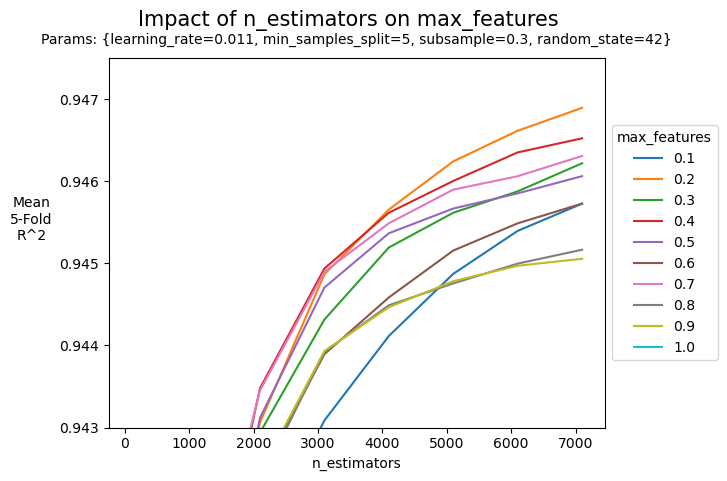

In [477]:
# PLOT - max_features changes with n_estimators
r2_df4.T.plot(linestyle='-')
plt.xlabel('n_estimators')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.suptitle('Impact of n_estimators on max_features', fontsize=15)
plt.title('Params: {learning_rate=0.011, min_samples_split=5, subsample=0.3, random_state=42}', fontsize=10, pad=10)
plt.ylim(0.943,0.9475)
# plt.ylim(0.93,0.9472)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('max_features')

# TOMORROW MORNING THIS IS WHERE YOU START!!!! NO TIME FOR GRID SEARCH APPROX BEST MODEL!

In [66]:
#NEXT STEPS (TOP FEATURES)
start_time = time.time()

gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
gbmr.fit(X,y)
feature_importances = gbmr.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
top_features_25 = list(feature_importance_df.Feature.head(25))
features_ranked_by_importance = list(feature_importance_df.Feature)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Elapsed Time: 4.02 seconds


In [480]:
features_ranked_by_importance[:10]

['TotalSF',
 'OverallQual',
 'GrLivArea',
 'ExterQual_n',
 'GarageCars',
 'Age',
 'TotalBsmtSF',
 'KitchenQual_n',
 'GarageArea',
 'BsmtFinSF1']

In [72]:
# ADDING FEATURES TEST
# With best parameters set, run the model on a loop increasing number of features each loop
# features are added by order of importanct from GradientBoostingRegressor().feature_importances_
# Takes approximately 3579.30 seconds (60 mins)

results_list_features = []

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(learning_rate=0.011, max_depth=3, min_samples_split=5, n_estimators=4000, subsample=0.3, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

used_features = []
for feature in features_ranked_by_importance:
    start_time1 = time.time()
    used_features.append(feature)
    Num_of_features = len(used_features)
    X1 = df_numerical[used_features] # Set new df for features
    r2_scores_f = cross_val_score(gbmr, X1, y, scoring='r2', cv=kf)
    results_list_features.append({
        'Num_of_features': Num_of_features, 'Fold 1 R2': r2_scores_f[0], 'Fold 2 R2': r2_scores_f[1], 
        'Fold 3 R2': r2_scores_f[2], 'Fold 4 R2': r2_scores_f[3], 'Fold 5 R2': r2_scores_f[4], 
        'Mean_R2': r2_scores_f.mean(), 'Standard Deviation': r2_scores_f.std()
    })

    end_time1 = time.time()
    elapsed_time1 = end_time1 - start_time
    elapsed_time2 = end_time1 - start_time1
    print(f"{Num_of_features} Features model fit in {elapsed_time2:.2f} seconds. Total Time: {elapsed_time1:.2f} seconds")

results_list_features_df = pd.DataFrame(results_list_features)
results_list_features_df

1 Features model fit in 8.07 seconds. Total Time: 8.07 seconds
2 Features model fit in 8.68 seconds. Total Time: 16.75 seconds
3 Features model fit in 11.15 seconds. Total Time: 27.90 seconds
4 Features model fit in 11.42 seconds. Total Time: 39.32 seconds
5 Features model fit in 12.05 seconds. Total Time: 51.37 seconds
6 Features model fit in 13.18 seconds. Total Time: 64.55 seconds
7 Features model fit in 15.48 seconds. Total Time: 80.03 seconds
8 Features model fit in 15.67 seconds. Total Time: 95.70 seconds
9 Features model fit in 17.48 seconds. Total Time: 113.18 seconds
10 Features model fit in 19.50 seconds. Total Time: 132.67 seconds
11 Features model fit in 21.86 seconds. Total Time: 154.54 seconds
12 Features model fit in 22.23 seconds. Total Time: 176.77 seconds
13 Features model fit in 24.65 seconds. Total Time: 201.42 seconds
14 Features model fit in 25.10 seconds. Total Time: 226.52 seconds
15 Features model fit in 26.63 seconds. Total Time: 253.15 seconds
16 Features mod

,Num_of_features,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,MLR Mean R2,Standard Deviation
0,1,0.67159,0.68624,0.71129,0.66477,0.53373,0.65352,0.06199
1,2,0.83445,0.85639,0.85372,0.84310,0.82375,0.84228,0.01213
2,3,0.83454,0.86475,0.85597,0.84579,0.82197,0.84460,0.01516
3,4,0.84407,0.86810,0.85765,0.85868,0.83510,0.85272,0.01168
4,5,0.85602,0.87911,0.87050,0.86330,0.84962,0.86371,0.01040
...,...,...,...,...,...,...,...,...
76,77,0.94658,0.93879,0.95552,0.94875,0.93252,0.94443,0.00800
77,78,0.94689,0.93865,0.95562,0.94809,0.93267,0.94438,0.00796
78,79,0.94807,0.93812,0.95550,0.94943,0.93264,0.94475,0.00824
79,80,0.94708,0.93852,0.95428,0.94916,0.93326,0.94446,0.00757


In [104]:
# results_list_features_df.loc[results_list_features_df['Mean_R2']in results_list_features_df['Mean_R2'].nlargest(3)]
results_list_features_df.loc[results_list_features_df['Mean_R2'].nlargest(5).index]

,Num_of_features,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation
62,63,0.94852,0.93921,0.95550,0.95022,0.93316,0.94532,0.00804
65,66,0.94851,0.94026,0.95492,0.94959,0.93307,0.94527,0.00770
67,68,0.94748,0.93925,0.95632,0.94945,0.93338,0.94517,0.00802
57,58,0.94821,0.93949,0.95568,0.94976,0.93262,0.94515,0.00813
59,60,0.94844,0.93961,0.95594,0.94946,0.93194,0.94508,0.00838


Text(0.5, 1.0, 'Params: {learning_rate=0.011, min_samples_split=5, subsample=0.3, random_state=42}')

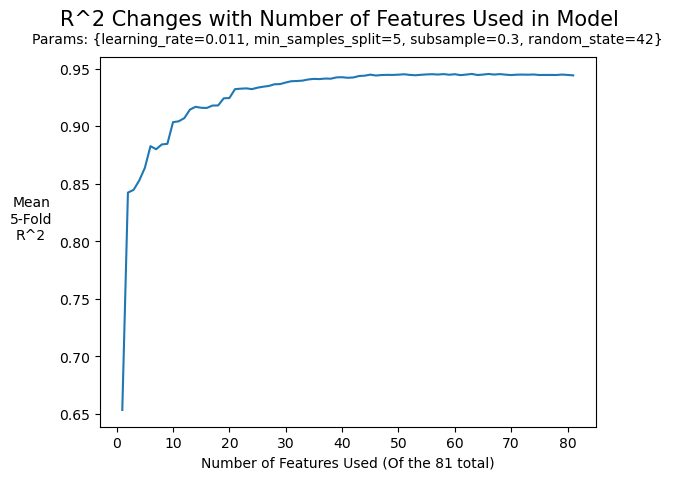

In [483]:
plt.plot(results_list_features_df['Num_of_features'], results_list_features_df['Mean_R2'])
plt.xlabel('Number of Features Used (Of the 81 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.suptitle('R^2 Changes with Number of Features Used in Model', fontsize=15)
plt.title('Params: {learning_rate=0.011, min_samples_split=5, subsample=0.3, random_state=42}', fontsize=10, pad=10)
# plt.ylim(0.941,0.9455)
# plt.xlim(40,81)

In [502]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib", message="No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.")

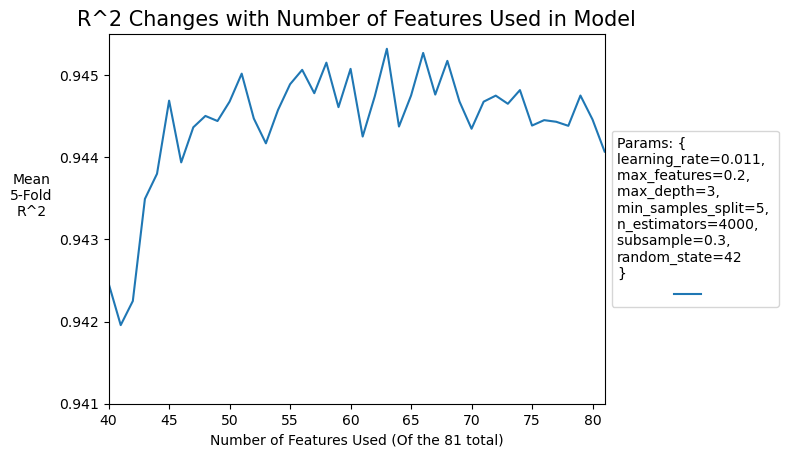

In [506]:
plt.plot(results_list_features_df['Num_of_features'], results_list_features_df['Mean_R2'], label=' ')
plt.xlabel('Number of Features Used (Of the 81 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.title('R^2 Changes with Number of Features Used in Model', fontsize=15)
plt.ylim(0.941,0.9455)
plt.xlim(40,81)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('Params: {\nlearning_rate=0.011, \
\nmax_features=0.2, \nmax_depth=3, \nmin_samples_split=5, \nn_estimators=4000, \nsubsample=0.3, \nrandom_state=42\n}')

# REDO WITH MAXFEATURES

In [99]:
# ADDING FEATURES TEST
# With best parameters set, run the model on a loop increasing number of features each loop
# features are added by order of importanct from GradientBoostingRegressor().feature_importances_
# Takes approximately 3579.30 seconds (60 mins)

results_list_features = []

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

used_features = []
for feature in features_ranked_by_importance:
    start_time1 = time.time()
    used_features.append(feature)
    Num_of_features = len(used_features)
    X1 = df_numerical[used_features] # Set new df for features
    r2_scores_f = cross_val_score(gbmr, X1, y, scoring='r2', cv=kf)
    results_list_features.append({
        'Num_of_features': Num_of_features, 'Feature_added': feature, 'Fold 1 R2': r2_scores_f[0], 
        'Fold 2 R2': r2_scores_f[1], 'Fold 3 R2': r2_scores_f[2], 'Fold 4 R2': r2_scores_f[3], 
        'Fold 5 R2': r2_scores_f[4], 'Mean_R2': r2_scores_f.mean(), 'Standard Deviation': r2_scores_f.std()
    })

    end_time1 = time.time()
    elapsed_time1 = end_time1 - start_time
    elapsed_time2 = end_time1 - start_time1
    print(f"{Num_of_features} Features model fit in {elapsed_time2:.2f} seconds. Total Time: {elapsed_time1:.2f} seconds")

features_df = pd.DataFrame(results_list_features)
features_df['R2_change'] = features_df['Mean_R2'].diff()

1 Features model fit in 8.27 seconds. Total Time: 8.28 seconds
2 Features model fit in 7.40 seconds. Total Time: 15.68 seconds
3 Features model fit in 7.63 seconds. Total Time: 23.31 seconds
4 Features model fit in 7.28 seconds. Total Time: 30.58 seconds
5 Features model fit in 7.03 seconds. Total Time: 37.61 seconds
6 Features model fit in 7.45 seconds. Total Time: 45.06 seconds
7 Features model fit in 7.40 seconds. Total Time: 52.47 seconds
8 Features model fit in 7.20 seconds. Total Time: 59.66 seconds
9 Features model fit in 7.26 seconds. Total Time: 66.92 seconds
10 Features model fit in 8.77 seconds. Total Time: 75.69 seconds
11 Features model fit in 9.01 seconds. Total Time: 84.70 seconds
12 Features model fit in 8.74 seconds. Total Time: 93.44 seconds
13 Features model fit in 9.07 seconds. Total Time: 102.52 seconds
14 Features model fit in 8.75 seconds. Total Time: 111.27 seconds
15 Features model fit in 10.11 seconds. Total Time: 121.38 seconds
16 Features model fit in 10.05 

Params: {learning_rate=0.011, max_depth=3, max_features= 0.2, min_samples_split=5,n_estimators=4000, subsample=0.3, random_state=42}


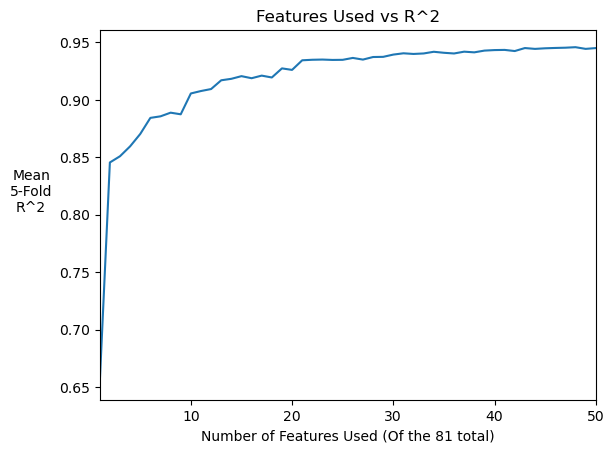

In [486]:
plt.plot(features_df['Num_of_features'], features_df['Mean_R2'])
plt.xlabel('Number of Features Used (Of the 81 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.title('Features Used vs R^2')
# plt.ylim(0.9437,0.9461)
plt.xlim(1,50)

print('Params: {learning_rate=0.011, max_depth=3, max_features= 0.2, min_samples_split=5,\
n_estimators=4000, subsample=0.3, random_state=42}')

In [170]:
start_time = time.time()

gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X2 = df_numerical[features_ranked_by_importance[:69]]
r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"\nAverage R^2 Score across the 5 folds: {r2_scores_f.mean():.6f}")

Elapsed Time: 15.86 seconds

Average R^2 Score across the 5 folds: 0.946027


# DROP THESE
test: highest r2 was at 69 vars.
- 69 r2 - 94603
- 70 r2 - 94525
- 71 r2 - 94521

when 70 was removed, 
- new 70 r2 - 94596


In [203]:
features_df.loc[68:70]

,Num_of_features,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change,feature_added
68,69,0.94953,0.94342,0.95416,0.94745,0.93558,0.94603,0.00626,0.00174,MasVnrType
69,70,0.94848,0.94111,0.95665,0.94521,0.93479,0.94525,0.00731,-0.00078,LowQualFinSF
70,71,0.94897,0.94088,0.95437,0.94720,0.93461,0.94521,0.00683,-0.00004,3SsnPorch


In [202]:
features_df.loc[14:17]

,Num_of_features,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change,feature_added
14,15,0.92336,0.91624,0.93138,0.92513,0.90682,0.92059,0.00840,0.00232,GarageYrBlt
15,16,0.92076,0.91665,0.92885,0.92105,0.90659,0.91878,0.00726,-0.00181,MasVnrArea
16,17,0.92539,0.92004,0.93289,0.92476,0.90214,0.92104,0.01031,0.00226,YearRemodAdd
17,18,0.92380,0.91916,0.92761,0.92510,0.90144,0.91942,0.00940,-0.00162,MiscRmsAbvGrd


In [189]:
features_df.sort_values('R2_change').head(10)

,Num_of_features,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change,feature_added
15,16,0.92076,0.91665,0.92885,0.92105,0.90659,0.91878,0.00726,-0.00181,MasVnrArea
64,65,0.94777,0.93884,0.95398,0.94602,0.93290,0.94390,0.00732,-0.00165,BsmtFinType2_n
17,18,0.92380,0.91916,0.92761,0.92510,0.90144,0.91942,0.00940,-0.00162,MiscRmsAbvGrd
67,68,0.94792,0.93875,0.95467,0.94527,0.93483,0.94429,0.00696,-0.00149,BsmtCond_n
48,49,0.94750,0.94020,0.95526,0.94456,0.93412,0.94433,0.00708,-0.00146,Foundation
26,27,0.94175,0.92928,0.94786,0.93605,0.92004,0.93500,0.00968,-0.00145,LotFrontage
8,9,0.88450,0.88990,0.89768,0.89136,0.87343,0.88738,0.00814,-0.00141,GarageArea
19,20,0.93239,0.92080,0.93874,0.92525,0.91295,0.92602,0.00896,-0.00132,2ndFlrSF
41,42,0.94479,0.93810,0.95549,0.94297,0.93083,0.94244,0.00812,-0.00099,MA_Zip1
34,35,0.94552,0.93673,0.95137,0.94126,0.92975,0.94092,0.00739,-0.00088,WoodDeckSF


# REMOVING FEATURES THAT DROPPED R2

In [208]:
features_ranked_by_importance2 = features_ranked_by_importance.copy()
features_ranked_by_importance2.remove('MasVnrArea')

In [209]:
# ADDING FEATURES TEST
# With best parameters set, run the model on a loop increasing number of features each loop
# features are added by order of importanct from GradientBoostingRegressor().feature_importances_
# Takes approximately 1073.79 seconds (18 mins)

results_list_features = []

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

used_features = []
for feature in features_ranked_by_importance2:
    start_time1 = time.time()
    used_features.append(feature)
    Num_of_features = len(used_features)
    X1 = df_numerical[used_features] # Set new df for features
    r2_scores_f = cross_val_score(gbmr, X1, y, scoring='r2', cv=kf)
    results_list_features.append({
        'Num_of_features': Num_of_features, 'Feature_added': feature, 'Fold 1 R2': r2_scores_f[0], 
        'Fold 2 R2': r2_scores_f[1], 'Fold 3 R2': r2_scores_f[2], 'Fold 4 R2': r2_scores_f[3], 
        'Fold 5 R2': r2_scores_f[4], 'Mean_R2': r2_scores_f.mean(), 'Standard Deviation': r2_scores_f.std()
    })

    end_time1 = time.time()
    elapsed_time1 = end_time1 - start_time
    elapsed_time2 = end_time1 - start_time1
    print(f"{Num_of_features} Features model fit in {elapsed_time2:.2f} seconds. Total Time: {elapsed_time1:.2f} seconds")

features_df2 = pd.DataFrame(results_list_features)
features_df2['R2_change'] = features_df2['Mean_R2'].diff()

1 Features model fit in 8.28 seconds. Total Time: 8.29 seconds
2 Features model fit in 7.33 seconds. Total Time: 15.62 seconds
3 Features model fit in 8.56 seconds. Total Time: 24.17 seconds
4 Features model fit in 7.26 seconds. Total Time: 31.43 seconds
5 Features model fit in 7.07 seconds. Total Time: 38.50 seconds
6 Features model fit in 7.11 seconds. Total Time: 45.60 seconds
7 Features model fit in 7.55 seconds. Total Time: 53.15 seconds
8 Features model fit in 7.12 seconds. Total Time: 60.27 seconds
9 Features model fit in 7.13 seconds. Total Time: 67.40 seconds
10 Features model fit in 8.57 seconds. Total Time: 75.97 seconds
11 Features model fit in 8.84 seconds. Total Time: 84.81 seconds
12 Features model fit in 8.59 seconds. Total Time: 93.40 seconds
13 Features model fit in 9.03 seconds. Total Time: 102.44 seconds
14 Features model fit in 8.68 seconds. Total Time: 111.12 seconds
15 Features model fit in 9.99 seconds. Total Time: 121.11 seconds
16 Features model fit in 10.34 s

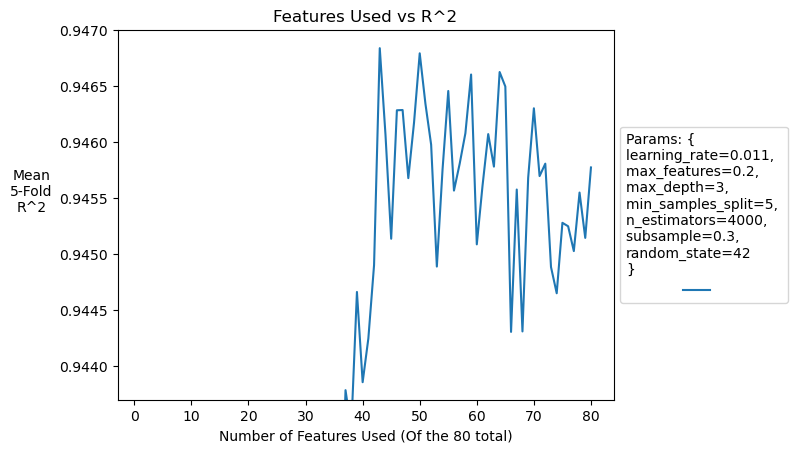

In [507]:
plt.plot(features_df2['Num_of_features'], features_df2['Mean_R2'], label = ' ')
plt.xlabel('Number of Features Used (Of the 80 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.title('Features Used vs R^2')
plt.ylim(0.9437,0.947)
# plt.xlim(1,50)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('Params: {\nlearning_rate=0.011, \
\nmax_features=0.2, \nmax_depth=3, \nmin_samples_split=5, \nn_estimators=4000, \nsubsample=0.3, \nrandom_state=42\n}')

In [214]:
features_df.sort_values('R2_change').head(10)

,Num_of_features,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change,feature_added
15,16,0.92076,0.91665,0.92885,0.92105,0.90659,0.91878,0.00726,-0.00181,MasVnrArea
64,65,0.94777,0.93884,0.95398,0.94602,0.93290,0.94390,0.00732,-0.00165,BsmtFinType2_n
17,18,0.92380,0.91916,0.92761,0.92510,0.90144,0.91942,0.00940,-0.00162,MiscRmsAbvGrd
67,68,0.94792,0.93875,0.95467,0.94527,0.93483,0.94429,0.00696,-0.00149,BsmtCond_n
48,49,0.94750,0.94020,0.95526,0.94456,0.93412,0.94433,0.00708,-0.00146,Foundation
26,27,0.94175,0.92928,0.94786,0.93605,0.92004,0.93500,0.00968,-0.00145,LotFrontage
8,9,0.88450,0.88990,0.89768,0.89136,0.87343,0.88738,0.00814,-0.00141,GarageArea
19,20,0.93239,0.92080,0.93874,0.92525,0.91295,0.92602,0.00896,-0.00132,2ndFlrSF
41,42,0.94479,0.93810,0.95549,0.94297,0.93083,0.94244,0.00812,-0.00099,MA_Zip1
34,35,0.94552,0.93673,0.95137,0.94126,0.92975,0.94092,0.00739,-0.00088,WoodDeckSF


In [216]:
features_df2.loc[features_df2.Num_of_features >10].sort_values('R2_change').tail(10)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
68,69,LowQualFinSF,0.94973,0.94155,0.95587,0.94655,0.93470,0.94568,0.00719,0.00174
29,30,longitude,0.94407,0.93594,0.95171,0.94470,0.92438,0.94016,0.00934,0.00196
10,11,1stFlrSF,0.90859,0.91402,0.91234,0.90974,0.89351,0.90764,0.00732,0.00212
27,28,BsmtFinType1_n,0.94545,0.93270,0.94975,0.94155,0.92120,0.93813,0.01016,0.00224
16,17,MiscRmsAbvGrd,0.92316,0.92199,0.93214,0.92684,0.89937,0.92070,0.01124,0.00226
14,15,GarageYrBlt,0.92336,0.91624,0.93138,0.92513,0.90682,0.92059,0.00840,0.00232
42,43,HeatingQC_n,0.95276,0.94417,0.95733,0.94584,0.93409,0.94684,0.00795,0.00261
12,13,LotArea,0.92253,0.91524,0.92716,0.91922,0.90077,0.91698,0.00900,0.00763
18,19,2ndFlrSF,0.93165,0.92470,0.94174,0.93020,0.91161,0.92798,0.00986,0.00792
20,21,latitude,0.94023,0.92972,0.94608,0.93729,0.92052,0.93477,0.00886,0.00836


In [217]:
features_df2.sort_values('Mean_R2',ascending=False).head(2)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
42,43,HeatingQC_n,0.95276,0.94417,0.95733,0.94584,0.93409,0.94684,0.00795,0.00261
49,50,LandContour,0.95173,0.94386,0.95676,0.94855,0.93306,0.94679,0.00805,0.00070


In [218]:
features_df.sort_values('Mean_R2',ascending=False).head(2)

,Num_of_features,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change,feature_added
68,69,0.94953,0.94342,0.95416,0.94745,0.93558,0.94603,0.00626,0.00174,MasVnrType
50,51,0.95020,0.93995,0.95571,0.94917,0.93471,0.94595,0.00756,0.00093,LandContour


# 2nd experiment: instead of going by feature importance order, go by which one improved R2 the most
DID NOT WORK -- Lowered max R2 from original (from 0.94603 to 0.94587)

In [229]:
features_ranked_by_r2_impact = list(features_df.sort_values('R2_change',ascending=False)['feature_added'])

In [230]:
# ADDING FEATURES TEST
# With best parameters set, run the model on a loop increasing number of features each loop
# features are added by order of importanct from features_ranked_by_r2_impact
# Takes approximately 952 seconds ( mins)

results_list_features = []

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

used_features = []
for feature in features_ranked_by_r2_impact:
    start_time1 = time.time()
    used_features.append(feature)
    Num_of_features = len(used_features)
    X1 = df_numerical[used_features] # Set new df for features
    r2_scores_f = cross_val_score(gbmr, X1, y, scoring='r2', cv=kf)
    results_list_features.append({
        'Num_of_features': Num_of_features, 'Feature_added': feature, 'Fold 1 R2': r2_scores_f[0], 
        'Fold 2 R2': r2_scores_f[1], 'Fold 3 R2': r2_scores_f[2], 'Fold 4 R2': r2_scores_f[3], 
        'Fold 5 R2': r2_scores_f[4], 'Mean_R2': r2_scores_f.mean(), 'Standard Deviation': r2_scores_f.std()
    })

    end_time1 = time.time()
    elapsed_time1 = end_time1 - start_time
    elapsed_time2 = end_time1 - start_time1
    print(f"{Num_of_features} Features model fit in {elapsed_time2:.2f} seconds. Total Time: {elapsed_time1:.2f} seconds")

features_df_impact = pd.DataFrame(results_list_features)
features_df_impact['R2_change'] = features_df['Mean_R2'].diff()

1 Features model fit in 6.69 seconds. Total Time: 6.69 seconds
2 Features model fit in 7.06 seconds. Total Time: 13.75 seconds
3 Features model fit in 7.11 seconds. Total Time: 20.86 seconds
4 Features model fit in 6.87 seconds. Total Time: 27.72 seconds
5 Features model fit in 6.73 seconds. Total Time: 34.45 seconds
6 Features model fit in 6.61 seconds. Total Time: 41.07 seconds
7 Features model fit in 6.65 seconds. Total Time: 47.71 seconds
8 Features model fit in 7.18 seconds. Total Time: 54.90 seconds
9 Features model fit in 7.02 seconds. Total Time: 61.91 seconds
10 Features model fit in 8.08 seconds. Total Time: 69.99 seconds
11 Features model fit in 7.97 seconds. Total Time: 77.96 seconds
12 Features model fit in 8.30 seconds. Total Time: 86.26 seconds
13 Features model fit in 8.48 seconds. Total Time: 94.74 seconds
14 Features model fit in 7.93 seconds. Total Time: 102.67 seconds
15 Features model fit in 9.22 seconds. Total Time: 111.89 seconds
16 Features model fit in 9.03 sec

Params: {learning_rate=0.011, max_depth=3, max_features= 0.2, min_samples_split=5,n_estimators=4000, subsample=0.3, random_state=42}


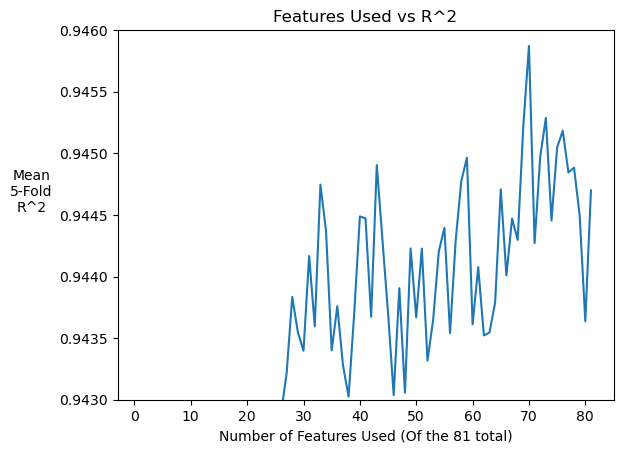

In [253]:
plt.plot(features_df_impact['Num_of_features'], features_df_impact['Mean_R2'])
plt.xlabel('Number of Features Used (Of the 81 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.title('Features Used vs R^2')
plt.ylim(0.943,0.946)
# plt.xlim(1,50)

print('Params: {learning_rate=0.011, max_depth=3, max_features= 0.2, min_samples_split=5,\
n_estimators=4000, subsample=0.3, random_state=42}')

# 3rd Experiment: go back to 1st exp (removed MasVnrArea) and remove next most negative feature

In [348]:
features_df2.sort_values('Mean_R2').tail(10)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
45,46,GarageCond_n,0.94919,0.94364,0.95756,0.94772,0.93332,0.94628,0.00791,0.00115
46,47,Exterior2nd,0.95003,0.94251,0.95814,0.94798,0.93278,0.94629,0.00841,0.00000
69,70,3SsnPorch,0.95095,0.94257,0.95712,0.94625,0.93462,0.94630,0.00760,0.00062
50,51,LotShape_n,0.94997,0.94187,0.95713,0.94945,0.93329,0.94634,0.00812,-0.00045
54,55,BedroomAbvGr,0.95136,0.94207,0.95590,0.94909,0.93387,0.94646,0.00772,0.00070
64,65,ExterCond_n,0.95132,0.94207,0.95743,0.94848,0.93319,0.94650,0.00829,-0.00013
58,59,PavedDrive,0.95091,0.94089,0.95811,0.94835,0.93476,0.94660,0.00808,0.00052
63,64,BsmtFinType2_n,0.95123,0.94430,0.95584,0.94847,0.93328,0.94663,0.00765,0.00084
49,50,LandContour,0.95173,0.94386,0.95676,0.94855,0.93306,0.94679,0.00805,0.00062
42,43,HeatingQC_n,0.95276,0.94417,0.95733,0.94584,0.93409,0.94684,0.00795,0.00194


In [316]:
# index with highest R2 score:
features_df_max = list(features_df.loc[features_df.Mean_R2 == features_df.Mean_R2.max()].index)[0]

# biggest R2 drop after filtering for values that come before the max
features_df_worst = list(features_df.loc[features_df.index < features_df_max].sort_values('R2_change').head(1).Feature_added)[0]
print(features_df_worst)

# create new df for next round
features_ranked_by_importance2 = features_ranked_by_importance.copy()
features_ranked_by_importance2.remove('MasVnrArea')

MasVnrArea


In [317]:
#index with highest R2 score:
features_df2_max = list(features_df2.loc[features_df2.Mean_R2 == features_df2.Mean_R2.max()].index)[0]

# biggest R2 drop after filtering for values that come before the max
features_df2_worst = list(features_df2.loc[features_df2.index < features_df2_max].sort_values('R2_change').head(1).Feature_added)[0]
print(features_df2_worst)

# create new df for next round
features_ranked_by_importance3 = features_ranked_by_importance2.copy()
features_ranked_by_importance3.remove(features_df2_worst)

MiscRmsAbvGrd


In [319]:
# ADDING FEATURES TEST
# With best parameters set, run the model on a loop increasing number of features each loop
# features are added by order of importanct from GradientBoostingRegressor().feature_importances_
# Takes approximately 1073.79 seconds (18 mins)

results_list_features = []

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

used_features = []
for feature in features_ranked_by_importance3:
    start_time1 = time.time()
    used_features.append(feature)
    Num_of_features = len(used_features)
    X1 = df_numerical[used_features] # Set new df for features
    r2_scores_f = cross_val_score(gbmr, X1, y, scoring='r2', cv=kf)
    results_list_features.append({
        'Num_of_features': Num_of_features, 'Feature_added': feature, 'Fold 1 R2': r2_scores_f[0], 
        'Fold 2 R2': r2_scores_f[1], 'Fold 3 R2': r2_scores_f[2], 'Fold 4 R2': r2_scores_f[3], 
        'Fold 5 R2': r2_scores_f[4], 'Mean_R2': r2_scores_f.mean(), 'Standard Deviation': r2_scores_f.std()
    })

    end_time1 = time.time()
    elapsed_time1 = end_time1 - start_time
    elapsed_time2 = end_time1 - start_time1
    print(f"{Num_of_features} Features model fit in {elapsed_time2:.2f} seconds. Total Time: {elapsed_time1:.2f} seconds")

features_df3 = pd.DataFrame(results_list_features)
features_df3['R2_change'] = features_df3['Mean_R2'].diff()

1 Features model fit in 8.02 seconds. Total Time: 8.02 seconds
2 Features model fit in 7.22 seconds. Total Time: 15.24 seconds
3 Features model fit in 7.58 seconds. Total Time: 22.82 seconds
4 Features model fit in 7.22 seconds. Total Time: 30.04 seconds
5 Features model fit in 7.00 seconds. Total Time: 37.04 seconds
6 Features model fit in 7.03 seconds. Total Time: 44.07 seconds
7 Features model fit in 7.31 seconds. Total Time: 51.39 seconds
8 Features model fit in 7.06 seconds. Total Time: 58.45 seconds
9 Features model fit in 7.17 seconds. Total Time: 65.62 seconds
10 Features model fit in 8.59 seconds. Total Time: 74.20 seconds
11 Features model fit in 8.94 seconds. Total Time: 83.15 seconds
12 Features model fit in 8.59 seconds. Total Time: 91.74 seconds
13 Features model fit in 8.77 seconds. Total Time: 100.51 seconds
14 Features model fit in 8.92 seconds. Total Time: 109.43 seconds
15 Features model fit in 10.04 seconds. Total Time: 119.47 seconds
16 Features model fit in 9.95 s

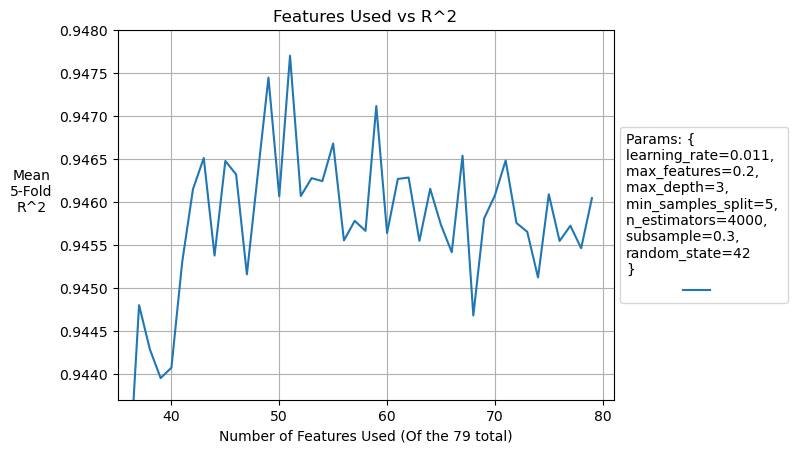

In [513]:
plt.plot(features_df3['Num_of_features'], features_df3['Mean_R2'], label = ' ')
plt.xlabel('Number of Features Used (Of the 79 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.title('Features Used vs R^2')
plt.ylim(0.9437,0.948)
plt.xlim(35,81)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('Params: {\nlearning_rate=0.011, \
\nmax_features=0.2, \nmax_depth=3, \nmin_samples_split=5, \nn_estimators=4000, \nsubsample=0.3, \nrandom_state=42\n}')
plt.grid(True)

In [327]:
#index with highest R2 score:
features_df3_max = list(features_df3.loc[features_df3.Mean_R2 == features_df3.Mean_R2.max()].index)[0]

# biggest R2 drop after filtering for values that come before the max
features_df3_worst = list(features_df3.loc[features_df3.index < features_df3_max].sort_values('R2_change').head(1).Feature_added)[0]
print(features_df3_worst)

# create new df for next round
features_ranked_by_importance4 = features_ranked_by_importance3.copy()
features_ranked_by_importance4.remove(features_df3_worst)

GarageArea


In [361]:
# ADDING FEATURES TEST
# With best parameters set, run the model on a loop increasing number of features each loop
# features are added by order of importanct from GradientBoostingRegressor().feature_importances_
# Takes approximately 1073.79 seconds (18 mins)

results_list_features = []

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

used_features = []
for feature in features_ranked_by_importance4:
    start_time1 = time.time()
    used_features.append(feature)
    Num_of_features = len(used_features)
    X1 = df_numerical[used_features] # Set new df for features
    r2_scores_f = cross_val_score(gbmr, X1, y, scoring='r2', cv=kf)
    results_list_features.append({
        'Num_of_features': Num_of_features, 'Feature_added': feature, 'Fold 1 R2': r2_scores_f[0], 
        'Fold 2 R2': r2_scores_f[1], 'Fold 3 R2': r2_scores_f[2], 'Fold 4 R2': r2_scores_f[3], 
        'Fold 5 R2': r2_scores_f[4], 'Mean_R2': r2_scores_f.mean(), 'Standard Deviation': r2_scores_f.std()
    })

    end_time1 = time.time()
    elapsed_time1 = end_time1 - start_time
    elapsed_time2 = end_time1 - start_time1
    print(f"{Num_of_features} Features model fit in {elapsed_time2:.2f} seconds. Total Time: {elapsed_time1:.2f} seconds")

features_df4 = pd.DataFrame(results_list_features)
features_df4['R2_change'] = features_df4['Mean_R2'].diff()

1 Features model fit in 8.69 seconds. Total Time: 8.69 seconds
2 Features model fit in 7.30 seconds. Total Time: 15.99 seconds
3 Features model fit in 7.68 seconds. Total Time: 23.67 seconds
4 Features model fit in 7.28 seconds. Total Time: 30.95 seconds
5 Features model fit in 7.05 seconds. Total Time: 38.00 seconds
6 Features model fit in 7.13 seconds. Total Time: 45.13 seconds
7 Features model fit in 7.26 seconds. Total Time: 52.39 seconds
8 Features model fit in 7.07 seconds. Total Time: 59.46 seconds
9 Features model fit in 7.16 seconds. Total Time: 66.62 seconds
10 Features model fit in 8.71 seconds. Total Time: 75.34 seconds
11 Features model fit in 8.53 seconds. Total Time: 83.86 seconds
12 Features model fit in 8.69 seconds. Total Time: 92.55 seconds
13 Features model fit in 8.86 seconds. Total Time: 101.41 seconds
14 Features model fit in 8.68 seconds. Total Time: 110.09 seconds
15 Features model fit in 9.89 seconds. Total Time: 119.98 seconds
16 Features model fit in 10.14 s

In [515]:
features_df4.sort_values('Mean_R2',ascending=False).head(1)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
59,60,KitchenAbvGr,0.94994,0.94596,0.95895,0.94835,0.93312,0.94726,0.00833,0.00043


In [518]:
features_df3.loc[features_df3.Feature_added=='GarageArea']

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
8,9,GarageArea,0.88450,0.88990,0.89768,0.89136,0.87343,0.88738,0.00814,-0.00141


In [363]:
features_df3.sort_values('Mean_R2',ascending=False).head(1)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
50,51,SaleType,0.94973,0.94471,0.96033,0.95029,0.93346,0.94770,0.00874,0.00164


In [370]:
features_df3.sort_values('R2_change').head(10)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
67,68,LowQualFinSF,0.94806,0.93962,0.95766,0.94641,0.93166,0.94468,0.00870,-0.00186
51,52,BsmtFinSF2,0.94967,0.94243,0.96004,0.94618,0.93202,0.94607,0.00915,-0.00163
59,60,GarageType,0.94641,0.94268,0.95769,0.94731,0.93410,0.94564,0.00762,-0.00148
8,9,GarageArea,0.88450,0.88990,0.89768,0.89136,0.87343,0.88738,0.00814,-0.00141
49,50,LotShape_n,0.94962,0.94167,0.95840,0.94830,0.93234,0.94607,0.00869,-0.00138
46,47,Foundation,0.94723,0.94022,0.95912,0.94689,0.93233,0.94516,0.00885,-0.00116
43,44,EnclosedPorch,0.94876,0.94031,0.95670,0.94773,0.93339,0.94538,0.00793,-0.00114
55,56,LandSlope_n,0.95005,0.94024,0.95783,0.94656,0.93307,0.94555,0.00844,-0.00113
30,31,DistanceToISU,0.94653,0.93495,0.95604,0.94286,0.92431,0.94094,0.01073,-0.00088
23,24,BsmtUnfSF,0.94386,0.93154,0.95041,0.94023,0.91833,0.93687,0.01109,-0.00084


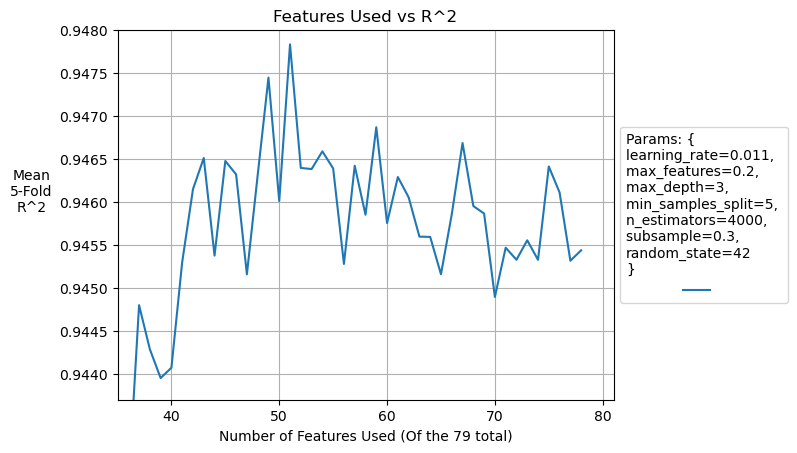

In [519]:
plt.plot(features_df4a['Num_of_features'], features_df4a['Mean_R2'], label = ' ')
plt.xlabel('Number of Features Used (Of the 79 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.title('Features Used vs R^2')
plt.ylim(0.9437,0.948)
plt.xlim(35,81)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('Params: {\nlearning_rate=0.011, \
\nmax_features=0.2, \nmax_depth=3, \nmin_samples_split=5, \nn_estimators=4000, \nsubsample=0.3, \nrandom_state=42\n}')
plt.grid(True)

# maybe garage area was too important (top 10)?  try removing that high 40s feature for round 4 instead

In [381]:
#index with highest R2 score:
features_df3_max = list(features_df3.loc[features_df3.Mean_R2 == features_df3.Mean_R2.max()].index)[0]

# biggest R2 drop after filtering for values that come before the max
features_df3_worst2 = list(features_df3.loc[features_df3.index < features_df3_max].sort_values('R2_change').head(2).Feature_added)[1]
print(features_df3_worst2)

# create new df for next round
features_ranked_by_importance4a = features_ranked_by_importance3.copy()
features_ranked_by_importance4a.remove(features_df3_worst2)

LotShape_n


In [382]:
# ADDING FEATURES TEST
# With best parameters set, run the model on a loop increasing number of features each loop
# features are added by order of importanct from GradientBoostingRegressor().feature_importances_
# Takes approximately 1073.79 seconds (18 mins)

results_list_features = []

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

used_features = []
for feature in features_ranked_by_importance4a:
    start_time1 = time.time()
    used_features.append(feature)
    Num_of_features = len(used_features)
    X1 = df_numerical[used_features] # Set new df for features
    r2_scores_f = cross_val_score(gbmr, X1, y, scoring='r2', cv=kf)
    results_list_features.append({
        'Num_of_features': Num_of_features, 'Feature_added': feature, 'Fold 1 R2': r2_scores_f[0], 
        'Fold 2 R2': r2_scores_f[1], 'Fold 3 R2': r2_scores_f[2], 'Fold 4 R2': r2_scores_f[3], 
        'Fold 5 R2': r2_scores_f[4], 'Mean_R2': r2_scores_f.mean(), 'Standard Deviation': r2_scores_f.std()
    })

    end_time1 = time.time()
    elapsed_time1 = end_time1 - start_time
    elapsed_time2 = end_time1 - start_time1
    print(f"{Num_of_features} Features model fit in {elapsed_time2:.2f} seconds. Total Time: {elapsed_time1:.2f} seconds")

features_df4a = pd.DataFrame(results_list_features)
features_df4a['R2_change'] = features_df4a['Mean_R2'].diff()

1 Features model fit in 8.01 seconds. Total Time: 8.01 seconds
2 Features model fit in 7.22 seconds. Total Time: 15.23 seconds
3 Features model fit in 7.63 seconds. Total Time: 22.86 seconds
4 Features model fit in 7.23 seconds. Total Time: 30.10 seconds
5 Features model fit in 7.01 seconds. Total Time: 37.11 seconds
6 Features model fit in 7.07 seconds. Total Time: 44.18 seconds
7 Features model fit in 7.23 seconds. Total Time: 51.41 seconds
8 Features model fit in 7.11 seconds. Total Time: 58.53 seconds
9 Features model fit in 7.71 seconds. Total Time: 66.23 seconds
10 Features model fit in 8.71 seconds. Total Time: 74.95 seconds
11 Features model fit in 9.22 seconds. Total Time: 84.17 seconds
12 Features model fit in 8.60 seconds. Total Time: 92.77 seconds
13 Features model fit in 8.79 seconds. Total Time: 101.56 seconds
14 Features model fit in 8.65 seconds. Total Time: 110.21 seconds
15 Features model fit in 10.02 seconds. Total Time: 120.23 seconds
16 Features model fit in 10.04 

In [521]:
features_df4a.sort_values('Mean_R2',ascending=False).head(10)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
50,51,BsmtFinSF2,0.94920,0.94371,0.96091,0.95087,0.93447,0.94783,0.00869,0.00182
48,49,LandContour,0.95065,0.94328,0.96011,0.94752,0.93568,0.94745,0.00808,0.00114
58,59,GarageType,0.95143,0.93987,0.95940,0.94913,0.93452,0.94687,0.00877,0.00102
66,67,LowQualFinSF,0.95096,0.94295,0.95696,0.94688,0.93568,0.94669,0.00720,0.00083
53,54,GarageQual_n,0.95012,0.94063,0.96013,0.94932,0.93276,0.94659,0.00928,0.00021
42,43,Condition1,0.95192,0.94120,0.95996,0.94523,0.93426,0.94651,0.00883,0.00036
44,45,GarageCond_n,0.95005,0.94169,0.95867,0.94899,0.93299,0.94648,0.00863,0.00110
56,57,PavedDrive,0.95063,0.94270,0.95744,0.94822,0.93312,0.94642,0.00816,0.00114
74,75,MiscFeature,0.95067,0.94262,0.95823,0.94733,0.93321,0.94641,0.00833,0.00109
51,52,LotConfig,0.95045,0.94240,0.96002,0.94567,0.93345,0.94640,0.00879,-0.00144


In [387]:
features_df4a.loc[47:52]

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
47,48,MSZoning,0.94942,0.94103,0.96010,0.94798,0.93302,0.94631,0.00903,0.00115
48,49,LandContour,0.95065,0.94328,0.96011,0.94752,0.93568,0.94745,0.00808,0.00114
49,50,SaleType,0.94988,0.94104,0.95853,0.94781,0.93279,0.94601,0.00865,-0.00144
50,51,BsmtFinSF2,0.94920,0.94371,0.96091,0.95087,0.93447,0.94783,0.00869,0.00182
51,52,LotConfig,0.95045,0.94240,0.96002,0.94567,0.93345,0.94640,0.00879,-0.00144
52,53,BedroomAbvGr,0.95074,0.94197,0.95749,0.94803,0.93369,0.94638,0.00807,-0.00001


In [386]:
features_df4a.sort_values('R2_change',ascending=True).head(10)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
51,52,LotConfig,0.95045,0.94240,0.96002,0.94567,0.93345,0.94640,0.00879,-0.00144
49,50,SaleType,0.94988,0.94104,0.95853,0.94781,0.93279,0.94601,0.00865,-0.00144
8,9,GarageArea,0.88450,0.88990,0.89768,0.89136,0.87343,0.88738,0.00814,-0.00141
46,47,Foundation,0.94723,0.94022,0.95912,0.94689,0.93233,0.94516,0.00885,-0.00116
43,44,EnclosedPorch,0.94876,0.94031,0.95670,0.94773,0.93339,0.94538,0.00793,-0.00114
59,60,KitchenAbvGr,0.94920,0.94149,0.95688,0.94688,0.93433,0.94575,0.00756,-0.00112
55,56,YrSold,0.95010,0.93931,0.95743,0.94671,0.93285,0.94528,0.00852,-0.00111
69,70,Fence,0.94887,0.94098,0.95788,0.94425,0.93250,0.94490,0.00841,-0.00097
30,31,DistanceToISU,0.94653,0.93495,0.95604,0.94286,0.92431,0.94094,0.01073,-0.00088
23,24,BsmtUnfSF,0.94386,0.93154,0.95041,0.94023,0.91833,0.93687,0.01109,-0.00084


# it was, removing Lotshape_n marginally improved best mean r2. 5th removal:
## again garage area but going straight to the second worst this round

In [587]:
#index with highest R2 score:
features_df4a_max = list(features_df4a.loc[features_df4a.Mean_R2 == features_df4a.Mean_R2.max()].index)[0]

# biggest R2 drop after filtering for values that come before the max
features_df4a_worst = list(features_df4a.loc[features_df4a.index < features_df4a_max].loc[
                           features_df4a.Feature_added!='GarageArea'].sort_values('R2_change').head(1).Feature_added)[0]

print(features_df4a_worst)

# create new df for next round
features_ranked_by_importance5 = features_ranked_by_importance4a.copy()
features_ranked_by_importance5.remove(features_df4a_worst)

SaleType


['SaleType']

In [393]:
# ADDING FEATURES TEST
# With best parameters set, run the model on a loop increasing number of features each loop
# features are added by order of importanct from GradientBoostingRegressor().feature_importances_
# Takes approximately 1073.79 seconds (18 mins)

results_list_features = []

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

used_features = []
for feature in features_ranked_by_importance5:
    start_time1 = time.time()
    used_features.append(feature)
    Num_of_features = len(used_features)
    X1 = df_numerical[used_features] # Set new df for features
    r2_scores_f = cross_val_score(gbmr, X1, y, scoring='r2', cv=kf)
    results_list_features.append({
        'Num_of_features': Num_of_features, 'Feature_added': feature, 'Fold 1 R2': r2_scores_f[0], 
        'Fold 2 R2': r2_scores_f[1], 'Fold 3 R2': r2_scores_f[2], 'Fold 4 R2': r2_scores_f[3], 
        'Fold 5 R2': r2_scores_f[4], 'Mean_R2': r2_scores_f.mean(), 'Standard Deviation': r2_scores_f.std()
    })

    end_time1 = time.time()
    elapsed_time1 = end_time1 - start_time
    elapsed_time2 = end_time1 - start_time1
    print(f"{Num_of_features} Features model fit in {elapsed_time2:.2f} seconds. Total Time: {elapsed_time1:.2f} seconds")

features_df5 = pd.DataFrame(results_list_features)
features_df5['R2_change'] = features_df5['Mean_R2'].diff()

1 Features model fit in 8.19 seconds. Total Time: 8.19 seconds
2 Features model fit in 7.31 seconds. Total Time: 15.50 seconds
3 Features model fit in 7.66 seconds. Total Time: 23.16 seconds
4 Features model fit in 7.28 seconds. Total Time: 30.44 seconds
5 Features model fit in 7.02 seconds. Total Time: 37.46 seconds
6 Features model fit in 7.09 seconds. Total Time: 44.55 seconds
7 Features model fit in 7.21 seconds. Total Time: 51.76 seconds
8 Features model fit in 7.12 seconds. Total Time: 58.88 seconds
9 Features model fit in 7.17 seconds. Total Time: 66.05 seconds
10 Features model fit in 9.12 seconds. Total Time: 75.17 seconds
11 Features model fit in 8.83 seconds. Total Time: 84.00 seconds
12 Features model fit in 8.67 seconds. Total Time: 92.67 seconds
13 Features model fit in 9.06 seconds. Total Time: 101.72 seconds
14 Features model fit in 8.70 seconds. Total Time: 110.42 seconds
15 Features model fit in 10.05 seconds. Total Time: 120.47 seconds
16 Features model fit in 10.00 

In [574]:
features_df5

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
0,1,TotalSF,0.67159,0.68624,0.71129,0.66477,0.53373,0.65352,0.06199,NaN
1,2,OverallQual,0.83561,0.85697,0.85224,0.85349,0.82886,0.84543,0.01109,0.19191
2,3,GrLivArea,0.83979,0.86961,0.85720,0.85573,0.83200,0.85087,0.01337,0.00543
3,4,ExterQual_n,0.84995,0.87211,0.86189,0.86689,0.84659,0.85949,0.00977,0.00862
4,5,GarageCars,0.86452,0.87957,0.87840,0.87561,0.85315,0.87025,0.01007,0.01077
...,...,...,...,...,...,...,...,...,...,...
72,73,MiscVal,0.94930,0.94306,0.95795,0.94813,0.93238,0.94616,0.00839,0.00000
73,74,MiscFeature,0.94710,0.94131,0.95739,0.94608,0.93265,0.94491,0.00807,-0.00126
74,75,Electrical,0.95164,0.94224,0.95837,0.94713,0.93233,0.94634,0.00879,0.00144
75,76,Condition2,0.94890,0.94023,0.95865,0.94514,0.93438,0.94546,0.00820,-0.00088


In [575]:
features_df6

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
0,1,TotalSF,0.64379,0.66907,0.68401,0.63778,0.50240,0.62741,0.06472,NaN
1,2,OverallQual,0.82953,0.85405,0.84973,0.83824,0.82484,0.83928,0.01124,0.21187
2,3,GrLivArea,0.83397,0.86710,0.85098,0.84596,0.82053,0.84371,0.01573,0.00443
3,4,ExterQual_n,0.84227,0.87070,0.85883,0.85963,0.83747,0.85378,0.01220,0.01007
4,5,GarageCars,0.85823,0.87716,0.87472,0.86665,0.84454,0.86426,0.01189,0.01048
...,...,...,...,...,...,...,...,...,...,...
72,73,MiscVal,0.95143,0.94441,0.95804,0.94895,0.93458,0.94748,0.00781,-0.00007
73,74,MiscFeature,0.94946,0.94328,0.95836,0.94707,0.93466,0.94657,0.00775,-0.00091
74,75,Electrical,0.95370,0.94384,0.95835,0.94784,0.93383,0.94751,0.00845,0.00095
75,76,Condition2,0.95135,0.94121,0.95909,0.94578,0.93641,0.94677,0.00790,-0.00075


In [394]:
features_df5.sort_values('R2_change',ascending=True).head(10)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
51,52,BedroomAbvGr,0.95039,0.94276,0.95901,0.94654,0.93290,0.94632,0.00861,-0.00146
8,9,GarageArea,0.88450,0.88990,0.89768,0.89136,0.87343,0.88738,0.00814,-0.00141
65,66,LowQualFinSF,0.94801,0.94003,0.95824,0.94398,0.93375,0.94480,0.00820,-0.00132
73,74,MiscFeature,0.94710,0.94131,0.95739,0.94608,0.93265,0.94491,0.00807,-0.00126
55,56,PavedDrive,0.95013,0.93934,0.95702,0.94568,0.93186,0.94481,0.00867,-0.00122
59,60,HouseStyle,0.94895,0.94242,0.95724,0.94632,0.93446,0.94588,0.00750,-0.00121
46,47,Foundation,0.94723,0.94022,0.95912,0.94689,0.93233,0.94516,0.00885,-0.00116
43,44,EnclosedPorch,0.94876,0.94031,0.95670,0.94773,0.93339,0.94538,0.00793,-0.00114
49,50,BsmtFinSF2,0.94970,0.94279,0.95912,0.94750,0.93321,0.94646,0.00849,-0.00099
30,31,DistanceToISU,0.94653,0.93495,0.95604,0.94286,0.92431,0.94094,0.01073,-0.00088


In [395]:
features_df5.sort_values('Mean_R2',ascending=False).head(10)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
50,51,LotConfig,0.94944,0.94404,0.96135,0.95097,0.93311,0.94778,0.00923,0.00132
48,49,LandContour,0.95065,0.94328,0.96011,0.94752,0.93568,0.94745,0.00808,0.00114
58,59,KitchenAbvGr,0.94961,0.94074,0.96025,0.95035,0.93447,0.94709,0.00883,0.00127
42,43,Condition1,0.95192,0.94120,0.95996,0.94523,0.93426,0.94651,0.00883,0.00036
44,45,GarageCond_n,0.95005,0.94169,0.95867,0.94899,0.93299,0.94648,0.00863,0.00110
49,50,BsmtFinSF2,0.94970,0.94279,0.95912,0.94750,0.93321,0.94646,0.00849,-0.00099
68,69,Fence,0.95053,0.94283,0.95689,0.94625,0.93539,0.94638,0.00723,0.00114
74,75,Electrical,0.95164,0.94224,0.95837,0.94713,0.93233,0.94634,0.00879,0.00144
45,46,Exterior2nd,0.94915,0.94091,0.95968,0.94902,0.93285,0.94632,0.00900,-0.00016
51,52,BedroomAbvGr,0.95039,0.94276,0.95901,0.94654,0.93290,0.94632,0.00861,-0.00146


In [400]:
features_df.sort_values('Mean_R2',ascending=False).head(1)

,Num_of_features,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change,Feature_added
68,69,0.94953,0.94342,0.95416,0.94745,0.93558,0.94603,0.00626,0.00174,MasVnrType


In [401]:
features_df2.sort_values('Mean_R2',ascending=False).head(1)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
42,43,HeatingQC_n,0.95276,0.94417,0.95733,0.94584,0.93409,0.94684,0.00795,0.00194


In [402]:
features_df3.sort_values('Mean_R2',ascending=False).head(1)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
50,51,SaleType,0.94973,0.94471,0.96033,0.95029,0.93346,0.94770,0.00874,0.00164


In [403]:
features_df4a.sort_values('Mean_R2',ascending=False).head(1)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
50,51,BsmtFinSF2,0.94920,0.94371,0.96091,0.95087,0.93447,0.94783,0.00869,0.00182


In [404]:
features_df5.sort_values('Mean_R2',ascending=False).head(1)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
50,51,LotConfig,0.94944,0.94404,0.96135,0.95097,0.93311,0.94778,0.00923,0.00132


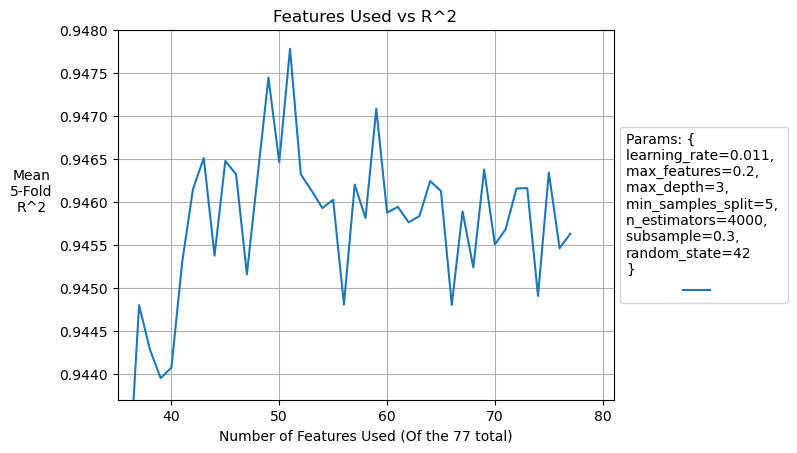

In [523]:
plt.plot(features_df5['Num_of_features'], features_df5['Mean_R2'], label = ' ')
plt.xlabel('Number of Features Used (Of the 77 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.title('Features Used vs R^2')
plt.ylim(0.9437,0.948)
plt.xlim(35,81)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('Params: {\nlearning_rate=0.011, \
\nmax_features=0.2, \nmax_depth=3, \nmin_samples_split=5, \nn_estimators=4000, \nsubsample=0.3, \nrandom_state=42\n}')
plt.grid(True)

In [622]:
print(features_df_worst)
print(features_df2_worst)
print(features_df3_worst)
print(features_df4a_worst)
print(features_df5_worst)
print(features_df6_worst)


MasVnrArea
MiscRmsAbvGrd
GarageArea
SaleType
Foundation
EnclosedPorch


# CHECKING FEATURE REMOVAL REULTS

In [444]:
print(f'features_df  Max R2 = {features_df.Mean_R2.max():.5f}')
print(f'features_df2 Max R2 = {features_df2.Mean_R2.max():.5f}')
print(f'features_df3 Max R2 = {features_df3.Mean_R2.max():.5f}')
print(f'features_df4 Max R2 = {features_df4.Mean_R2.max():.5f}')
print(f'features_df4aMax R2 = {features_df4a.Mean_R2.max():.5f}')
print(f'features_df5 Max R2 = {features_df5.Mean_R2.max():.5f}')

print(f'\nfeatures_df_impact Max R2 = {features_df_impact.Mean_R2.max():.5f}')


features_df  Max R2 = 0.94603
features_df2 Max R2 = 0.94684
features_df3 Max R2 = 0.94770
features_df4 Max R2 = 0.94726
features_df4aMax R2 = 0.94783
features_df5 Max R2 = 0.94778

features_df_impact Max R2 = 0.94587


In [554]:
feature_count = 81
for df in [estimators_test_df, estimators_test_df2, estimators_test_df3, estimators_test_df4, estimators_test_df5]:  
    print(f'Number of features used: {feature_count}')
    feature_count -=1
    print(f'Maximum R^2 Score of {df.Mean_R2.max():.5f} when using {df.loc[df.Mean_R2 == df.Mean_R2.max()].iat[0,0]} n_estimators\n')

Number of features used: 81
Maximum R^2 Score of 0.94880 when using 8000 n_estimators

Number of features used: 80
Maximum R^2 Score of 0.94880 when using 8000 n_estimators

Number of features used: 79
Maximum R^2 Score of 0.94880 when using 8000 n_estimators

Number of features used: 78
Maximum R^2 Score of 0.94867 when using 8000 n_estimators

Number of features used: 77
Maximum R^2 Score of 0.94895 when using 8000 n_estimators



In [550]:
estimators_test_df.loc[estimators_test_df.Mean_R2 == estimators_test_df.Mean_R2.max()].iat[0,1]

0.9487973858153989

Elapsed Time: 30.38 seconds


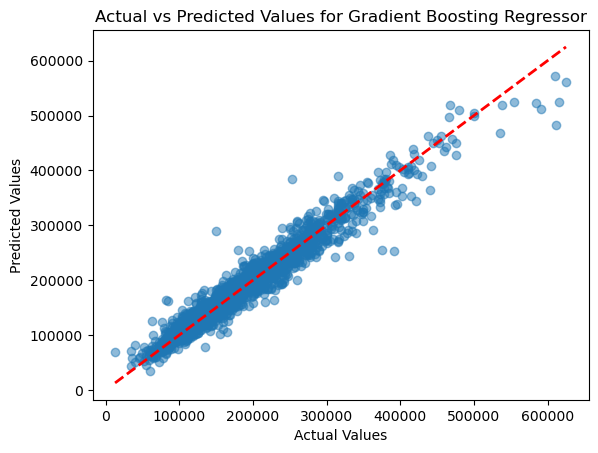

In [555]:
from sklearn.model_selection import cross_val_predict

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=8000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X2 = df_numerical[features_ranked_by_importance5[:51]]
y_pred = cross_val_predict(gbmr, X2, y, cv=kf)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

plt.scatter(y, y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle="--", color='red', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Gradient Boosting Regressor")
plt.show()

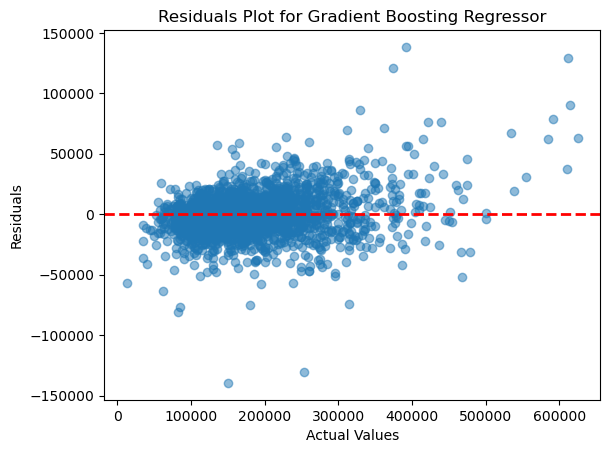

In [556]:
residuals = y - y_pred
plt.scatter(y, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot for Gradient Boosting Regressor")
plt.show()

In [463]:
# Identify high-residual points
# threshold = 50000  # You can adjust this threshold based on your data and requirements
print(f'R^2 initial:            {r2}')

for threshold in [40000,45000,50000,55000,60000]:
    high_residual_indices = np.abs(residuals) > threshold
    
    # Create a new DataFrame excluding high-residual points
    X_filtered = X[~high_residual_indices]
    y_filtered = y[~high_residual_indices]
    
    # Train the model on the filtered data
    gbmr.fit(X_filtered, y_filtered)
    
    # Perform cross-validation and get predicted values
    y_pred_filtered = cross_val_predict(model, X_filtered, y_filtered, cv=kf)
    
    
    print(f'Residuals more than {threshold} from target removed')
    print(f'removed {len(y_pred) - len(y_pred_filtered)} observations')
    r2 = r2_score(y, y_pred)
    r2_filtered = r2_score(y_filtered, y_pred_filtered)
    print(f'R^2 (Filtered): {r2_filtered}')


R^2 initial:            0.9486850726492859
Residuals more than 40000 from target removed
removed 80 observations
R^2 (Filtered): 0.961012006500269
Residuals more than 45000 from target removed
removed 56 observations
R^2 (Filtered): 0.9598809036922368
Residuals more than 50000 from target removed
removed 39 observations
R^2 (Filtered): 0.9594578827172344
Residuals more than 55000 from target removed
removed 34 observations
R^2 (Filtered): 0.9569899955922061
Residuals more than 60000 from target removed
removed 23 observations
R^2 (Filtered): 0.954795925566169


In [464]:
len(y_pred)


2577

[100,
 250,
 500,
 750,
 1000,
 1500,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 11000,
 12000]

In [591]:
start_time = time.time()
estimators_test4 = []
for i in list(range(1000,9001,1000)):
    gbmr = GradientBoostingRegressor()
    gbmr.set_params(
        max_features= 0.2,
        learning_rate=0.011, 
        max_depth=3, 
        min_samples_split=5,
        n_estimators=i, 
        subsample=0.3, 
        random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X2 = df_numerical[features_ranked_by_importance[:69]]
    r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)
    estimators_test4.append({'n_estimators':i, 'Mean_R2':r2_scores_f.mean()})
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds. df4a nestimators: {i}")
estimators_test_df = pd.DataFrame(estimators_test4)

start_time = time.time()
estimators_test4 = []
for i in list(range(1000,9001,1000)):
    gbmr = GradientBoostingRegressor()
    gbmr.set_params(
        max_features= 0.2,
        learning_rate=0.011, 
        max_depth=3, 
        min_samples_split=5,
        n_estimators=i, 
        subsample=0.3, 
        random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X2 = df_numerical[features_ranked_by_importance2[:43]]
    r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)
    estimators_test4.append({'n_estimators':i, 'Mean_R2':r2_scores_f.mean()})
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds. df4a nestimators: {i}")
estimators_test_df2 = pd.DataFrame(estimators_test4)

start_time = time.time()
estimators_test4 = []
for i in list(range(1000,9001,1000)):
    gbmr = GradientBoostingRegressor()
    gbmr.set_params(
        max_features= 0.2,
        learning_rate=0.011, 
        max_depth=3, 
        min_samples_split=5,
        n_estimators=i, 
        subsample=0.3, 
        random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X2 = df_numerical[features_ranked_by_importance3[:51]]
    r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)
    estimators_test4.append({'n_estimators':i, 'Mean_R2':r2_scores_f.mean()})
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds. df4a nestimators: {i}")
estimators_test_df3 = pd.DataFrame(estimators_test4)

Elapsed Time: 4.03 seconds. df4a nestimators: 1000
Elapsed Time: 12.49 seconds. df4a nestimators: 2000
Elapsed Time: 24.39 seconds. df4a nestimators: 3000
Elapsed Time: 40.44 seconds. df4a nestimators: 4000
Elapsed Time: 60.77 seconds. df4a nestimators: 5000
Elapsed Time: 85.11 seconds. df4a nestimators: 6000
Elapsed Time: 113.14 seconds. df4a nestimators: 7000
Elapsed Time: 145.82 seconds. df4a nestimators: 8000
Elapsed Time: 182.62 seconds. df4a nestimators: 9000
Elapsed Time: 3.68 seconds. df4a nestimators: 1000
Elapsed Time: 11.00 seconds. df4a nestimators: 2000
Elapsed Time: 22.43 seconds. df4a nestimators: 3000
Elapsed Time: 37.08 seconds. df4a nestimators: 4000
Elapsed Time: 55.46 seconds. df4a nestimators: 5000
Elapsed Time: 77.45 seconds. df4a nestimators: 6000
Elapsed Time: 102.99 seconds. df4a nestimators: 7000
Elapsed Time: 132.43 seconds. df4a nestimators: 8000
Elapsed Time: 165.47 seconds. df4a nestimators: 9000
Elapsed Time: 3.91 seconds. df4a nestimators: 1000
Elapsed T

In [592]:
feature_count = 81
for df in [estimators_test_df, estimators_test_df2, estimators_test_df3, estimators_test_df4, estimators_test_df5]:  
    print(f'Number of features used: {feature_count}')
    feature_count -=1
    print(f'Maximum R^2 Score of {df.Mean_R2.max():.5f} when using {df.loc[df.Mean_R2 == df.Mean_R2.max()].iat[0,0]} n_estimators\n')

Number of features used: 81
Maximum R^2 Score of 0.94709 when using 8000 n_estimators

Number of features used: 80
Maximum R^2 Score of 0.94793 when using 8000 n_estimators

Number of features used: 79
Maximum R^2 Score of 0.94880 when using 8000 n_estimators

Number of features used: 78
Maximum R^2 Score of 0.94867 when using 8000 n_estimators

Number of features used: 77
Maximum R^2 Score of 0.94895 when using 8000 n_estimators



In [433]:
start_time = time.time()
estimators_test4 = []
for i in list(range(1000,12001,1000)):
    gbmr = GradientBoostingRegressor()
    gbmr.set_params(
        max_features= 0.2,
        learning_rate=0.011, 
        max_depth=3, 
        min_samples_split=5,
        n_estimators=i, 
        subsample=0.3, 
        random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X2 = df_numerical[features_ranked_by_importance4a[:51]]
    r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)
    estimators_test4.append({'n_estimators':i, 'Mean_R2':r2_scores_f.mean()})
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds. df4a nestimators: {i}")
estimators_test_df4 = pd.DataFrame(estimators_test4)

start_time = time.time()
estimators_test3 = []
for i in list(range(1000,12001,1000)):
    gbmr = GradientBoostingRegressor()
    gbmr.set_params(
        max_features= 0.2,
        learning_rate=0.011, 
        max_depth=3, 
        min_samples_split=5,
        n_estimators=i, 
        subsample=0.3, 
        random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X2 = df_numerical[features_ranked_by_importance3[:51]]
    r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)
    estimators_test3.append({'n_estimators':i, 'Mean_R2':r2_scores_f.mean()})
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds. df3 nestimators: {i}")
estimators_test_df3 = pd.DataFrame(estimators_test3)

Elapsed Time: 4.07 seconds. df4a nestimators: 1000
Elapsed Time: 11.70 seconds. df4a nestimators: 2000
Elapsed Time: 23.03 seconds. df4a nestimators: 3000
Elapsed Time: 38.14 seconds. df4a nestimators: 4000
Elapsed Time: 57.07 seconds. df4a nestimators: 5000
Elapsed Time: 80.07 seconds. df4a nestimators: 6000
Elapsed Time: 107.40 seconds. df4a nestimators: 7000
Elapsed Time: 138.41 seconds. df4a nestimators: 8000
Elapsed Time: 173.31 seconds. df4a nestimators: 9000
Elapsed Time: 212.35 seconds. df4a nestimators: 10000
Elapsed Time: 255.34 seconds. df4a nestimators: 11000
Elapsed Time: 302.48 seconds. df4a nestimators: 12000
Elapsed Time: 3.92 seconds. df3 nestimators: 1000
Elapsed Time: 11.67 seconds. df3 nestimators: 2000
Elapsed Time: 23.37 seconds. df3 nestimators: 3000
Elapsed Time: 38.93 seconds. df3 nestimators: 4000
Elapsed Time: 58.50 seconds. df3 nestimators: 5000
Elapsed Time: 81.77 seconds. df3 nestimators: 6000
Elapsed Time: 108.88 seconds. df3 nestimators: 7000
Elapsed Tim

In [437]:
estimators_test_df2

,n_estimators,Mean_R2
0,4000,0.94770
1,5000,0.94814
2,6000,0.94849
3,7000,0.94873
4,8000,0.94880
5,9000,0.94877
6,4000,0.94684
7,5000,0.94717
8,6000,0.94756
9,7000,0.94776


In [435]:
estimators_test_df4

,n_estimators,Mean_R2
0,1000,0.94081
1,2000,0.94549
2,3000,0.94691
3,4000,0.94783
4,5000,0.94809
5,6000,0.94841
6,7000,0.94859
7,8000,0.94867
8,9000,0.94862
9,10000,0.94857


In [398]:
start_time = time.time()
estimators_test = []
for i in list(range(4000,11001,1000)):
    gbmr = GradientBoostingRegressor()
    gbmr.set_params(
        max_features= 0.2,
        learning_rate=0.011, 
        max_depth=3, 
        min_samples_split=5,
        n_estimators=i, 
        subsample=0.3, 
        random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X2 = df_numerical[features_ranked_by_importance5[:51]]
    r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)
    estimators_test.append({'n_estimators':i, 'Mean_R2':r2_scores_f.mean()})
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
estimators_test_df5 = pd.DataFrame(estimators_test)

Elapsed Time: 15.34 seconds
Elapsed Time: 34.27 seconds
Elapsed Time: 56.95 seconds
Elapsed Time: 83.49 seconds
Elapsed Time: 113.73 seconds
Elapsed Time: 148.17 seconds
Elapsed Time: 186.81 seconds
Elapsed Time: 229.40 seconds


In [438]:
estimators_test_df5

,n_estimators,Mean_R2
0,4000,0.94778
1,5000,0.94811
2,6000,0.94864
3,7000,0.94886
4,8000,0.94895
5,9000,0.94893
6,10000,0.94894
7,11000,0.94892


In [349]:
start_time = time.time()
estimators_test2 = []
for i in list(range(4000,9001,1000)):
    gbmr = GradientBoostingRegressor()
    gbmr.set_params(
        max_features= 0.2,
        learning_rate=0.011, 
        max_depth=3, 
        min_samples_split=5,
        n_estimators=i, 
        subsample=0.3, 
        random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X2 = df_numerical[features_ranked_by_importance2[:43]]
    r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)
    estimators_test.append({'n_estimators':i, 'Mean_R2':r2_scores_f.mean()})
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
estimators_test_df2 = pd.DataFrame(estimators_test)

Elapsed Time: 14.47 seconds
Elapsed Time: 32.32 seconds
Elapsed Time: 53.76 seconds
Elapsed Time: 79.10 seconds
Elapsed Time: 107.63 seconds
Elapsed Time: 139.80 seconds


In [439]:
estimators_test_df2

,n_estimators,Mean_R2
0,4000,0.94770
1,5000,0.94814
2,6000,0.94849
3,7000,0.94873
4,8000,0.94880
5,9000,0.94877
6,4000,0.94684
7,5000,0.94717
8,6000,0.94756
9,7000,0.94776


In [ ]:
features_ranked_by_importance4 = features_ranked_by_importance3.copy()
features_ranked_by_importance4.remove('YearRemodAd

In [318]:

for i,j in zip(['features_df', 'features_df2', 'features_df3'],[features_df, features_df2, features_df3]):
    k = j.loc[j.Mean_R2 == j.Mean_R2.max()][['Num_of_features','Mean_R2','Feature_added']]
    print(f'{i}\n{k}')


features_df
    Num_of_features  Mean_R2 Feature_added
68               69  0.94603    MasVnrType
features_df2
    Num_of_features  Mean_R2 Feature_added
42               43  0.94684   HeatingQC_n
features_df3
    Num_of_features  Mean_R2 Feature_added
50               51  0.94701      SaleType


features_df  Max R2 = 0.94603
features_df2 Max R2 = 0.94684
features_df3 Max R2 = 0.94770
features_df4 Max R2 = 0.94726
features_df4aMax R2 = 0.94783
features_df5 Max R2 = 0.94778

features_df_impact Max R2 = 0.94587


# Tests to check R2 of model

In [179]:
start_time = time.time()

gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X3 = X.drop(),axis=1)
r2_scores_f = cross_val_score(gbmr, X3, y, scoring='r2', cv=kf)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"\nAverage R^2 Score across the 5 folds: {r2_scores_f.mean():.6f}")

Elapsed Time: 14.96 seconds

Average R^2 Score across the 5 folds: 0.945128


In [184]:
start_time = time.time()

gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X2 = df_numerical[features_ranked_by_importance[:70]]
r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"\nAverage R^2 Score across the 5 folds: {r2_scores_f.mean():.6f}")

Elapsed Time: 16.57 seconds

Average R^2 Score across the 5 folds: 0.945251


In [186]:
start_time = time.time()

gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=4000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X2 = df_numerical[features_ranked_by_importance2[:70]]
r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"\nAverage R^2 Score across the 5 folds: {r2_scores_f.mean():.6f}")

Elapsed Time: 16.60 seconds

Average R^2 Score across the 5 folds: 0.945957


In [185]:
features_ranked_by_importance2 = features_ranked_by_importance.copy()
features_ranked_by_importance2.remove('LowQualFinSF')
features_ranked_by_importance2

['TotalSF',
 'OverallQual',
 'GrLivArea',
 'ExterQual_n',
 'GarageCars',
 'Age',
 'TotalBsmtSF',
 'KitchenQual_n',
 'GarageArea',
 'BsmtFinSF1',
 '1stFlrSF',
 'BsmtQual_n',
 'LotArea',
 'FireplaceQu_n',
 'GarageYrBlt',
 'MasVnrArea',
 'YearRemodAdd',
 'MiscRmsAbvGrd',
 'Neighborhood',
 '2ndFlrSF',
 'OverallCond',
 'latitude',
 'Bath',
 'GarageFinish_n',
 'Fireplaces',
 'BsmtUnfSF',
 'LotFrontage',
 'BsmtExposure_n',
 'BsmtFinType1_n',
 'SaleCondition',
 'longitude',
 'BsmtBath',
 'DistanceToISU',
 'ScreenPorch',
 'WoodDeckSF',
 'OpenPorchSF',
 'MSSubClass',
 'MoSold',
 'Functional_n',
 'BldgType',
 'CentralAir',
 'MA_Zip1',
 'Exterior1st',
 'HeatingQC_n',
 'Condition1',
 'EnclosedPorch',
 'GarageCond_n',
 'Exterior2nd',
 'Foundation',
 'MSZoning',
 'LandContour',
 'LotShape_n',
 'SaleType',
 'BsmtFinSF2',
 'LotConfig',
 'BedroomAbvGr',
 'GarageQual_n',
 'LandSlope_n',
 'YrSold',
 'PavedDrive',
 'RoofStyle',
 'GarageType',
 'KitchenAbvGr',
 'HouseStyle',
 'BsmtFinType2_n',
 'ExterCond_n

In [442]:
start_time = time.time()
# estimators_test = []
for i in list(range(0000,3001,1000)):
    gbmr = XGBRegressor()
    gbmr.set_params(
        max_features= 0.2,
        learning_rate=0.011, 
        max_depth=3, 
        min_samples_split=5,
        n_estimators=i, 
        subsample=0.3, 
        random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X2 = df_numerical[features_ranked_by_importance5[:51]]
    r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)
    estimators_test.append({'n_estimators':i, 'Mean_R2':r2_scores_f.mean()})
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
estimators_test_df_xgb = pd.DataFrame(estimators_test)

Elapsed Time: 0.14 seconds
Elapsed Time: 2.58 seconds
Elapsed Time: 6.91 seconds
Elapsed Time: 13.58 seconds


In [443]:
estimators_test_df_xgb

,n_estimators,Mean_R2
0,4000,0.94501
1,5000,0.94540
2,6000,0.94553
3,7000,0.94557
4,8000,0.94554
5,9000,0.94548
6,0,-5.80365
7,1000,0.93836
8,2000,0.94259
9,3000,0.94435


In [596]:
print(f'{features_df.Mean_R2.max():5f}')
print(f'{features_df2.Mean_R2.max():5f}')
print(f'{features_df3.Mean_R2.max():5f}')
print(f'{features_df4a.Mean_R2.max():5f}')
print(f'{features_df5.Mean_R2.max():5f}')
print(f'{features_df6.Mean_R2.max():5f}')

0.946027
0.946839
0.947702
0.947834
0.947783
0.949055


# test 6!

In [588]:
#index with highest R2 score:
features_df5_max = list(features_df5.loc[features_df5.Mean_R2 == features_df5.Mean_R2.max()].index)[0]

# biggest R2 drop after filtering for values that come before the max
features_df5_worst = list(features_df5.loc[features_df5.index < features_df5_max].loc[
                           features_df5.Feature_added!='GarageArea'].sort_values('R2_change').head(1).Feature_added)[0]

print(features_df5_worst)

# create new df for next round
features_ranked_by_importance6 = features_ranked_by_importance5.copy()
features_ranked_by_importance6.remove(features_df5_worst)

Foundation


In [589]:
# ADDING FEATURES TEST
# With best parameters set, run the model on a loop increasing number of features each loop
# features are added by order of importanct from GradientBoostingRegressor().feature_importances_
# Takes approximately 1073.79 seconds (18 mins)

results_list_features = []

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=8000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

used_features = []
for feature in features_ranked_by_importance6:
    start_time1 = time.time()
    used_features.append(feature)
    Num_of_features = len(used_features)
    X1 = df_numerical[used_features] # Set new df for features
    r2_scores_f = cross_val_score(gbmr, X1, y, scoring='r2', cv=kf)
    results_list_features.append({
        'Num_of_features': Num_of_features, 'Feature_added': feature, 'Fold 1 R2': r2_scores_f[0], 
        'Fold 2 R2': r2_scores_f[1], 'Fold 3 R2': r2_scores_f[2], 'Fold 4 R2': r2_scores_f[3], 
        'Fold 5 R2': r2_scores_f[4], 'Mean_R2': r2_scores_f.mean(), 'Standard Deviation': r2_scores_f.std()
    })

    end_time1 = time.time()
    elapsed_time1 = end_time1 - start_time
    elapsed_time2 = end_time1 - start_time1
    print(f"{Num_of_features} Features model fit in {elapsed_time2:.2f} seconds. Total Time: {elapsed_time1:.2f} seconds")

features_df6 = pd.DataFrame(results_list_features)
features_df6['R2_change'] = features_df6['Mean_R2'].diff()

1 Features model fit in 17.09 seconds. Total Time: 17.09 seconds
2 Features model fit in 16.07 seconds. Total Time: 33.16 seconds
3 Features model fit in 17.22 seconds. Total Time: 50.38 seconds
4 Features model fit in 15.61 seconds. Total Time: 65.99 seconds
5 Features model fit in 15.26 seconds. Total Time: 81.24 seconds
6 Features model fit in 15.40 seconds. Total Time: 96.65 seconds
7 Features model fit in 15.67 seconds. Total Time: 112.31 seconds
8 Features model fit in 15.40 seconds. Total Time: 127.71 seconds
9 Features model fit in 16.00 seconds. Total Time: 143.71 seconds
10 Features model fit in 18.67 seconds. Total Time: 162.38 seconds
11 Features model fit in 19.12 seconds. Total Time: 181.50 seconds
12 Features model fit in 18.71 seconds. Total Time: 200.22 seconds
13 Features model fit in 19.50 seconds. Total Time: 219.71 seconds
14 Features model fit in 18.83 seconds. Total Time: 238.55 seconds
15 Features model fit in 22.26 seconds. Total Time: 260.81 seconds
16 Feature

In [590]:
features_df6.sort_values('Mean_R2',ascending=False)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
50,51,BedroomAbvGr,0.95222,0.94480,0.96123,0.95111,0.93592,0.94906,0.00840,0.00085
48,49,BsmtFinSF2,0.95221,0.94354,0.96018,0.94795,0.93817,0.94841,0.00751,0.00132
54,55,PavedDrive,0.95231,0.94280,0.96032,0.94986,0.93655,0.94837,0.00814,0.00124
49,50,LotConfig,0.95318,0.94343,0.95951,0.94908,0.93584,0.94821,0.00811,-0.00020
57,58,KitchenAbvGr,0.95178,0.94343,0.96112,0.94843,0.93574,0.94810,0.00846,0.00124
...,...,...,...,...,...,...,...,...,...,...
4,5,GarageCars,0.85823,0.87716,0.87472,0.86665,0.84454,0.86426,0.01189,0.01048
3,4,ExterQual_n,0.84227,0.87070,0.85883,0.85963,0.83747,0.85378,0.01220,0.01007
2,3,GrLivArea,0.83397,0.86710,0.85098,0.84596,0.82053,0.84371,0.01573,0.00443
1,2,OverallQual,0.82953,0.85405,0.84973,0.83824,0.82484,0.83928,0.01124,0.21187


In [567]:
features_df6.sort_values('Mean_R2',ascending=False)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
50,51,LotConfig,0.95210,0.94454,0.96179,0.95194,0.93436,0.94895,0.00912,0.00161
48,49,LandContour,0.95234,0.94379,0.96079,0.94806,0.93740,0.94847,0.00789,0.00130
58,59,KitchenAbvGr,0.95115,0.94168,0.96043,0.95129,0.93623,0.94816,0.00841,0.00101
68,69,Fence,0.95279,0.94403,0.95735,0.94721,0.93724,0.94772,0.00696,0.00077
52,53,GarageQual_n,0.95269,0.94228,0.95879,0.94841,0.93610,0.94765,0.00790,0.00031
...,...,...,...,...,...,...,...,...,...,...
4,5,GarageCars,0.85823,0.87716,0.87472,0.86665,0.84454,0.86426,0.01189,0.01048
3,4,ExterQual_n,0.84227,0.87070,0.85883,0.85963,0.83747,0.85378,0.01220,0.01007
2,3,GrLivArea,0.83397,0.86710,0.85098,0.84596,0.82053,0.84371,0.01573,0.00443
1,2,OverallQual,0.82953,0.85405,0.84973,0.83824,0.82484,0.83928,0.01124,0.21187


In [568]:
features_df5.sort_values('Mean_R2',ascending=False)

,Num_of_features,Feature_added,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,Mean_R2,Standard Deviation,R2_change
50,51,LotConfig,0.94944,0.94404,0.96135,0.95097,0.93311,0.94778,0.00923,0.00132
48,49,LandContour,0.95065,0.94328,0.96011,0.94752,0.93568,0.94745,0.00808,0.00114
58,59,KitchenAbvGr,0.94961,0.94074,0.96025,0.95035,0.93447,0.94709,0.00883,0.00127
42,43,Condition1,0.95192,0.94120,0.95996,0.94523,0.93426,0.94651,0.00883,0.00036
44,45,GarageCond_n,0.95005,0.94169,0.95867,0.94899,0.93299,0.94648,0.00863,0.00110
...,...,...,...,...,...,...,...,...,...,...
4,5,GarageCars,0.86452,0.87957,0.87840,0.87561,0.85315,0.87025,0.01007,0.01077
3,4,ExterQual_n,0.84995,0.87211,0.86189,0.86689,0.84659,0.85949,0.00977,0.00862
2,3,GrLivArea,0.83979,0.86961,0.85720,0.85573,0.83200,0.85087,0.01337,0.00543
1,2,OverallQual,0.83561,0.85697,0.85224,0.85349,0.82886,0.84543,0.01109,0.19191


In [584]:
print(len(features_ranked_by_importance6))
print(len(features_ranked_by_importance5))
print(len(features_ranked_by_importance5))
li1 = features_ranked_by_importance6 
li2 = features_ranked_by_importance5

temp3 = []
for element in li1:
    if element not in li2:
        temp3.append(element)
temp3

77
76
76


['Foundation']

In [585]:
len(features_ranked_by_importance5)

76

# Test 7

In [597]:
#index with highest R2 score:
features_df6_max = list(features_df6.loc[features_df6.Mean_R2 == features_df6.Mean_R2.max()].index)[0]

# biggest R2 drop after filtering for values that come before the max
features_df6_worst = list(features_df6.loc[features_df6.index < features_df6_max].loc[
                           features_df6.Feature_added!='GarageArea'].sort_values('R2_change').head(1).Feature_added)[0]

print(features_df6_worst)

# create new df for next round
features_ranked_by_importance7 = features_ranked_by_importance6.copy()
features_ranked_by_importance7.remove(features_df6_worst)

EnclosedPorch


In [601]:
# ADDING FEATURES TEST
# With best parameters set, run the model on a loop increasing number of features each loop
# features are added by order of importanct from GradientBoostingRegressor().feature_importances_
# Takes approximately 1073.79 seconds (18 mins)

results_list_features = []

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=8000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

used_features = []
for feature in features_ranked_by_importance7:
    start_time1 = time.time()
    used_features.append(feature)
    Num_of_features = len(used_features)
    X1 = df_numerical[used_features] # Set new df for features
    r2_scores_f = cross_val_score(gbmr, X1, y, scoring='r2', cv=kf)
    results_list_features.append({
        'Num_of_features': Num_of_features, 'Feature_added': feature, 'Fold 1 R2': r2_scores_f[0], 
        'Fold 2 R2': r2_scores_f[1], 'Fold 3 R2': r2_scores_f[2], 'Fold 4 R2': r2_scores_f[3], 
        'Fold 5 R2': r2_scores_f[4], 'Mean_R2': r2_scores_f.mean(), 'Standard Deviation': r2_scores_f.std()
    })

    end_time1 = time.time()
    elapsed_time1 = end_time1 - start_time
    elapsed_time2 = end_time1 - start_time1
    print(f"{Num_of_features} Features model fit in {elapsed_time2:.2f} seconds. Total Time: {elapsed_time1:.2f} seconds")

features_df7 = pd.DataFrame(results_list_features)
features_df7['R2_change'] = features_df6['Mean_R2'].diff()
print(f'{features_df7.Mean_R2.max():5f}')

1 Features model fit in 16.75 seconds. Total Time: 16.75 seconds
2 Features model fit in 14.48 seconds. Total Time: 31.24 seconds
3 Features model fit in 15.60 seconds. Total Time: 46.84 seconds
4 Features model fit in 14.46 seconds. Total Time: 61.30 seconds
5 Features model fit in 14.01 seconds. Total Time: 75.31 seconds
6 Features model fit in 14.63 seconds. Total Time: 89.93 seconds
7 Features model fit in 14.74 seconds. Total Time: 104.67 seconds
8 Features model fit in 14.32 seconds. Total Time: 118.99 seconds
9 Features model fit in 15.00 seconds. Total Time: 134.00 seconds
10 Features model fit in 17.45 seconds. Total Time: 151.44 seconds
11 Features model fit in 17.97 seconds. Total Time: 169.42 seconds
12 Features model fit in 17.65 seconds. Total Time: 187.07 seconds
13 Features model fit in 18.02 seconds. Total Time: 205.09 seconds
14 Features model fit in 17.88 seconds. Total Time: 222.96 seconds
15 Features model fit in 21.00 seconds. Total Time: 243.96 seconds
16 Feature

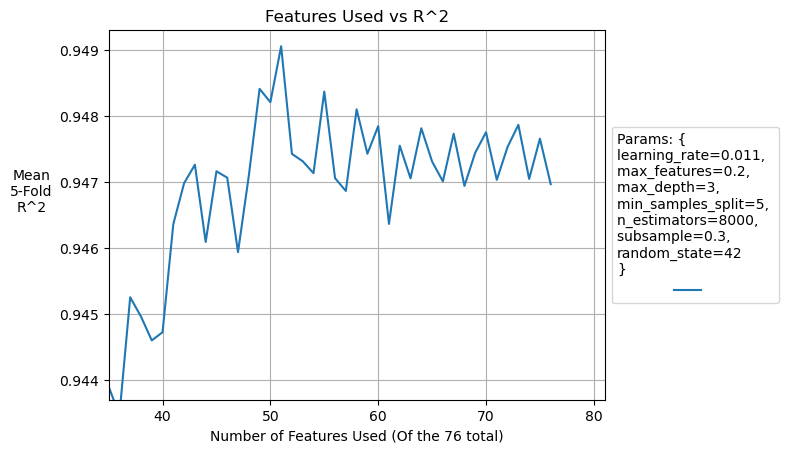

In [614]:
plt.plot(features_df6['Num_of_features'], features_df6['Mean_R2'], label = ' ')
plt.xlabel('Number of Features Used (Of the 76 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.title('Features Used vs R^2')
plt.ylim(0.9437,0.9493)
plt.xlim(35,81)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('Params: {\nlearning_rate=0.011, \
\nmax_features=0.2, \nmax_depth=3, \nmin_samples_split=5, \nn_estimators=8000, \nsubsample=0.3, \nrandom_state=42\n}')
plt.grid(True)

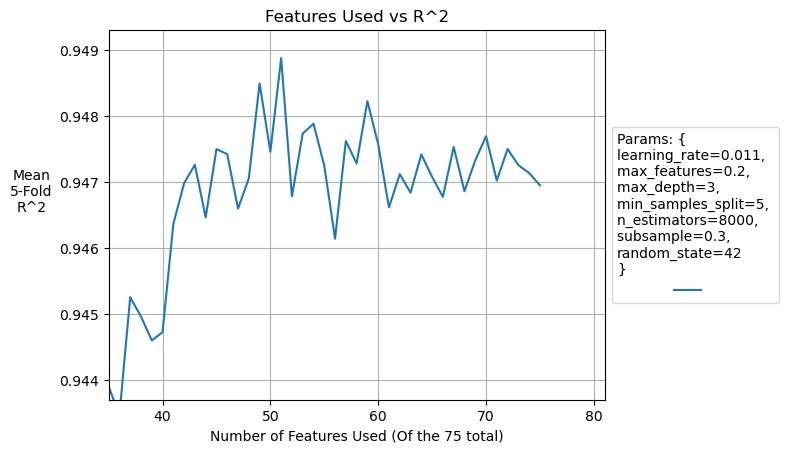

In [613]:
plt.plot(features_df7['Num_of_features'], features_df7['Mean_R2'], label = ' ')
plt.xlabel('Number of Features Used (Of the 75 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.title('Features Used vs R^2')
plt.ylim(0.9437,0.9493)
plt.xlim(35,81)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('Params: {\nlearning_rate=0.011, \
\nmax_features=0.2, \nmax_depth=3, \nmin_samples_split=5, \nn_estimators=8000, \nsubsample=0.3, \nrandom_state=42\n}')
plt.grid(True)

# Model 6 is the best

Elapsed Time: 42.28 seconds


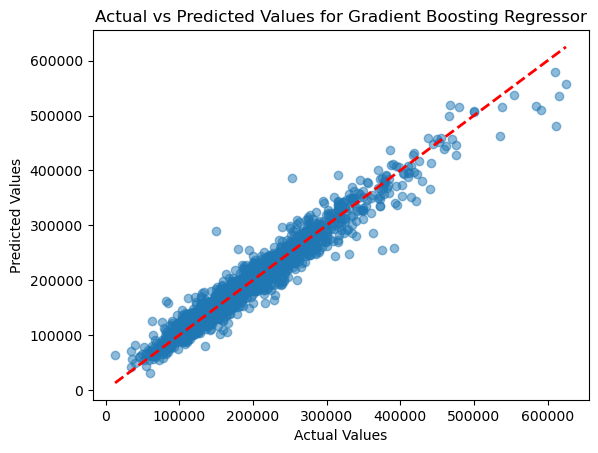

In [619]:
from sklearn.model_selection import cross_val_predict

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=11000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X2 = df_numerical[features_ranked_by_importance6[:51]]
y_pred = cross_val_predict(gbmr, X2, y, cv=kf)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

plt.scatter(y, y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle="--", color='red', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Gradient Boosting Regressor")
plt.show()

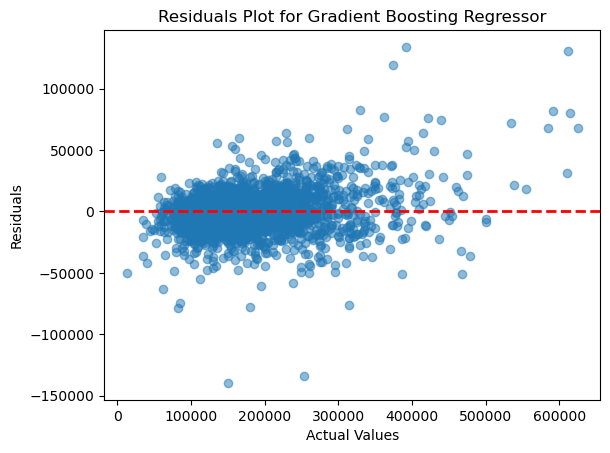

In [620]:
residuals = y - y_pred
plt.scatter(y, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot for Gradient Boosting Regressor")
plt.show()

## IS IT???

In [617]:
start_time = time.time()
estimators_test = []
for i in list(range(1000,12001,1000)):
    gbmr = GradientBoostingRegressor()
    gbmr.set_params(
        max_features= 0.2,
        learning_rate=0.011, 
        max_depth=3, 
        min_samples_split=5,
        n_estimators=i, 
        subsample=0.3, 
        random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X2 = df_numerical[features_ranked_by_importance6[:51]]
    r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)
    estimators_test.append({'n_estimators':i, 'Mean_R2':r2_scores_f.mean()})
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds. features_df6 n_estimators: {i}")
estimators_test_df6 = pd.DataFrame(estimators_test)

start_time = time.time()
estimators_test = []
for i in list(range(1000,12001,1000)):
    gbmr = GradientBoostingRegressor()
    gbmr.set_params(
        max_features= 0.2,
        learning_rate=0.011, 
        max_depth=3, 
        min_samples_split=5,
        n_estimators=i, 
        subsample=0.3, 
        random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X2 = df_numerical[features_ranked_by_importance7[:51]]
    r2_scores_f = cross_val_score(gbmr, X2, y, scoring='r2', cv=kf)
    estimators_test.append({'n_estimators':i, 'Mean_R2':r2_scores_f.mean()})
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds. features_df7 n_estimators: {i}")
estimators_test_df7 = pd.DataFrame(estimators_test)

Elapsed Time: 4.01 seconds. features_df6 n_estimators: 1000
Elapsed Time: 11.67 seconds. features_df6 n_estimators: 2000
Elapsed Time: 23.14 seconds. features_df6 n_estimators: 3000
Elapsed Time: 38.34 seconds. features_df6 n_estimators: 4000
Elapsed Time: 57.21 seconds. features_df6 n_estimators: 5000
Elapsed Time: 79.87 seconds. features_df6 n_estimators: 6000
Elapsed Time: 106.75 seconds. features_df6 n_estimators: 7000
Elapsed Time: 137.04 seconds. features_df6 n_estimators: 8000
Elapsed Time: 171.72 seconds. features_df6 n_estimators: 9000
Elapsed Time: 210.16 seconds. features_df6 n_estimators: 10000
Elapsed Time: 252.39 seconds. features_df6 n_estimators: 11000
Elapsed Time: 299.26 seconds. features_df6 n_estimators: 12000
Elapsed Time: 3.87 seconds. features_df7 n_estimators: 1000
Elapsed Time: 11.60 seconds. features_df7 n_estimators: 2000
Elapsed Time: 23.21 seconds. features_df7 n_estimators: 3000
Elapsed Time: 39.11 seconds. features_df7 n_estimators: 4000
Elapsed Time: 58.

In [618]:
feature_count = 81
for df in [estimators_test_df, estimators_test_df2, estimators_test_df3, estimators_test_df4, estimators_test_df5, estimators_test_df6, estimators_test_df7]:  
    print(f'Number of features used: {feature_count}')
    feature_count -=1
    print(f'Maximum R^2 Score of {df.Mean_R2.max():.5f} when using {df.loc[df.Mean_R2 == df.Mean_R2.max()].iat[0,0]} n_estimators\n')

Number of features used: 81
Maximum R^2 Score of 0.94709 when using 8000 n_estimators

Number of features used: 80
Maximum R^2 Score of 0.94793 when using 8000 n_estimators

Number of features used: 79
Maximum R^2 Score of 0.94880 when using 8000 n_estimators

Number of features used: 78
Maximum R^2 Score of 0.94867 when using 8000 n_estimators

Number of features used: 77
Maximum R^2 Score of 0.94895 when using 8000 n_estimators

Number of features used: 76
Maximum R^2 Score of 0.94917 when using 11000 n_estimators

Number of features used: 75
Maximum R^2 Score of 0.94912 when using 11000 n_estimators



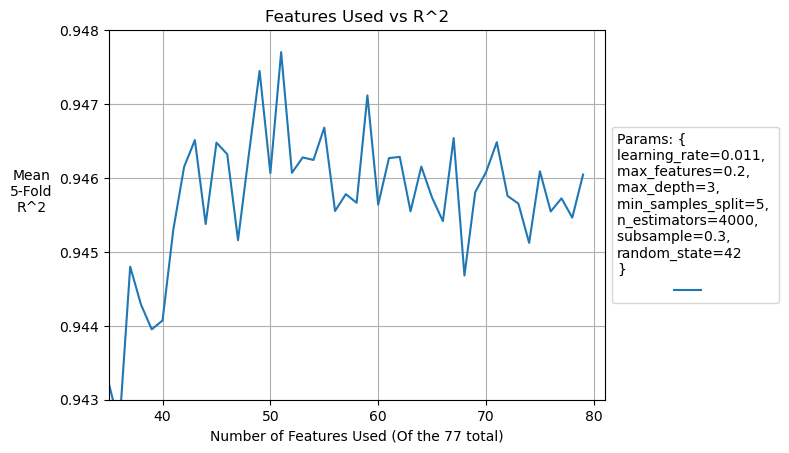

In [625]:
plt.plot(features_df['Num_of_features'], features_df['Mean_R2'], label = ' ')
plt.xlabel('Number of Features Used (Of the 77 total)')
plt.ylabel('Mean\n5-Fold\nR^2', rotation=0, labelpad=20)
plt.title('Features Used vs R^2')
plt.ylim(0.943,0.948)
plt.xlim(35,81)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_title('Params: {\nlearning_rate=0.011, \
\nmax_features=0.2, \nmax_depth=3, \nmin_samples_split=5, \nn_estimators=4000, \nsubsample=0.3, \nrandom_state=42\n}')
plt.grid(True)

# yes it is

Elapsed Time: 42.52 seconds


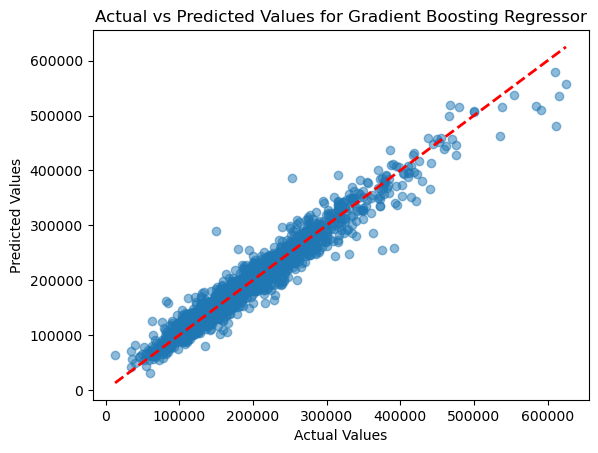

In [626]:
from sklearn.model_selection import cross_val_predict

start_time = time.time()
gbmr = GradientBoostingRegressor()
gbmr.set_params(
    max_features= 0.2,
    learning_rate=0.011, 
    max_depth=3, 
    min_samples_split=5,
    n_estimators=11000, 
    subsample=0.3, 
    random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X2 = df_numerical[features_ranked_by_importance6[:51]]
y_pred = cross_val_predict(gbmr, X2, y, cv=kf)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

plt.scatter(y, y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle="--", color='red', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Gradient Boosting Regressor")
plt.show()

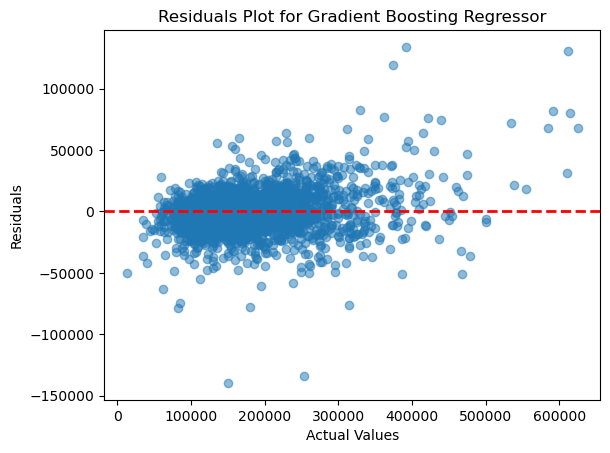

In [627]:
residuals = y - y_pred
plt.scatter(y, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot for Gradient Boosting Regressor")
plt.show()

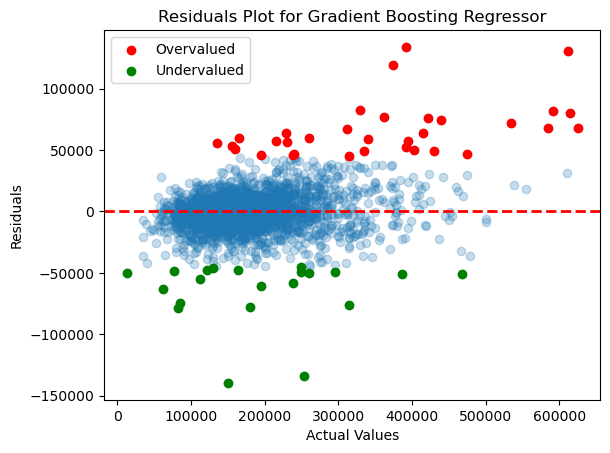

In [633]:
upper_threshold = 45000
lower_threshold = -45000
above_upper_threshold = residuals > upper_threshold
below_lower_threshold = residuals < lower_threshold
plt.scatter(y, residuals, alpha=0.25)
plt.scatter(y[above_upper_threshold], residuals[above_upper_threshold], c='red', label='Overvalued')
plt.scatter(y[below_lower_threshold], residuals[below_lower_threshold], c='green', label='Undervalued')
plt.legend()
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot for Gradient Boosting Regressor")
plt.show()